In [2]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [3]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm

In [4]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python")

In [5]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [56]:
# data_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq"

sample = "Sample_N705_-_ER1"
# quant_params = "raw-reads/pc-decoys-k17-1.4.0/forceCells-3000-noWh"
quant_params = "raw-reads/pc-decoys-k17-1.4.0/forceCells-3000-noWh"
# sample = "BT20"
# quant_params = "trimmed-reads-cutadapt/all-decoys-k17/forceCells-3000/raw"
project = "dsp779"
cell_line="HCC70"

### Plotting parameters

In [779]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DeJavu Serif'

### Raw CB frequency

In [8]:
y = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw/{cond}/alevin/raw_cb_frequency.txt", header=None)[1]

NameError: name 'cond' is not defined

In [ ]:
plt.title(f"MCF7 {cond} \n Raw library sizes distribution")
plt.ylim(0,2600);
plt.xlabel("# reads associated with a CB")
plt.ylabel("# cellular barcodes (CB)")
RNAseq.plot_loghist(y, bins=300)

In [ ]:
x = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw/{cond}/alevin/featureDump.txt")

In [ ]:
plt.title(f"MCF7 {cond} \n Library sizes distribution after CB correction")
plt.xlabel("# reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["CorrectedReads"], bins=150)

In [ ]:
plt.title(f"MCF7 {cond} \n Library sizes distribution after CB correction \n and mapping")
plt.xlabel("# mapped reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["MappedReads"], bins=100)

In [ ]:
plt.title(f"MCF7 {cond} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["DeduplicatedReads"], bins=150)

In [ ]:
plt.title(f"MCF7 {cond} \n Deduplication rate")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
plt.hist(x["DedupRate"], bins=150);

In [ ]:
i = x["DedupRate"]<0.5
plt.title(f"{cond} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
RNAseq.plot_loghist(x["DeduplicatedReads"][~i], bins=150)

### Loading raw count matrix

In [57]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, cdna = "3' tag", exp = "sc")

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [58]:
rnaseq.setup.annotate_samples(sc, samples_annot_name = "cell_lines", samples_annot = cell_line)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "source", samples_annot = "labo")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "samples", samples_annot = cell_line, ow = True)

rnaseq.setup.annotate_genes(sc, "external_gene_name")
sc.var["external_gene_name"]["EGFP"] = "EGFP"
rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "rp_frac")

Annotating cell_lines...
Annotating source...
Annotating samples...
Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating total_UMIs...
Annotating #_genes...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...
Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating rp_frac...
external_gene_name already annotated. Set ow = True if you want to overwrite.


In [487]:
sc.X.shape

(3997, 60240)

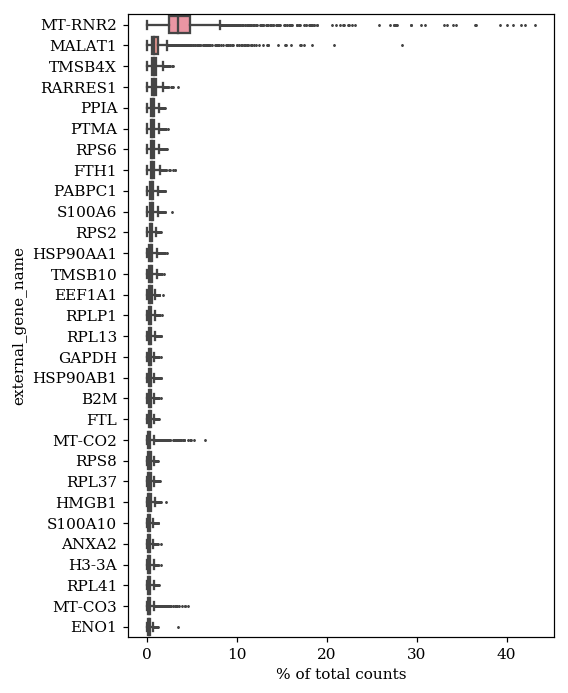

In [489]:
scanpy.pl.highest_expr_genes(sc, gene_symbols="external_gene_name")

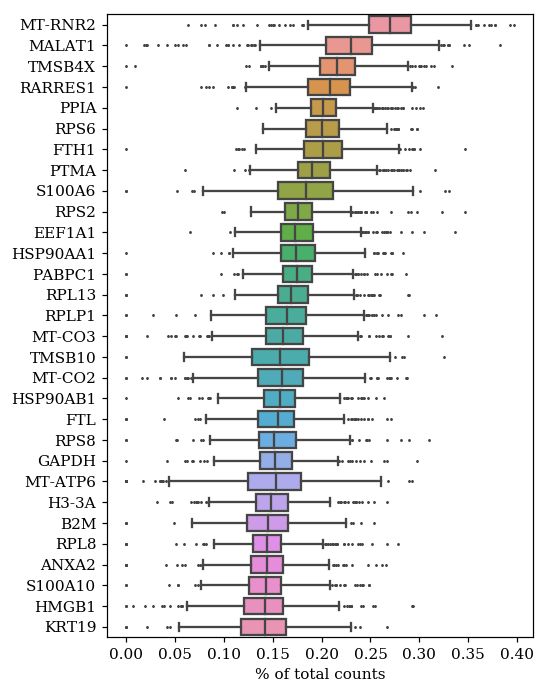

In [523]:
scanpy.pl.highest_expr_genes(sc)

### Non stringent filtering

__QC before filtering__

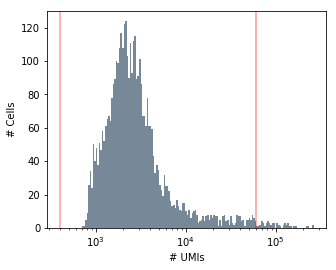

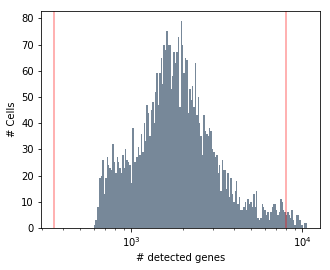

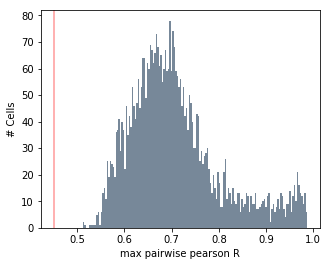

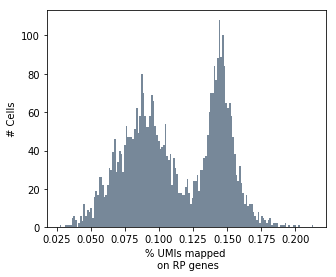

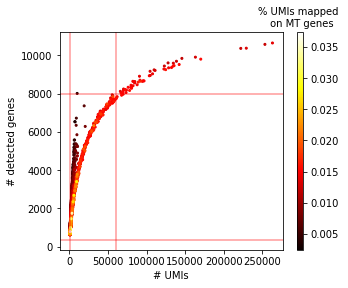

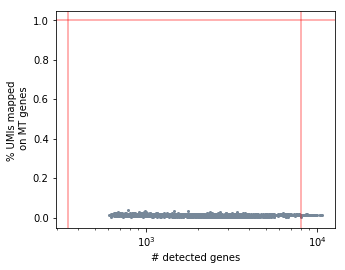

In [59]:
rnaseq.pp.plot_qc(sc, n_counts_max=60000, n_counts_min = 400, n_genes_max=8000, n_genes_min = 350, mt_max = 1, max_corr_thr = 0.45, n_bins = 150)

__Filtering cells__

In [784]:
rnaseq.pp.filter_cells(sc, n_counts_max=60000, n_counts_min = 400, n_genes_max=8000, n_genes_min = 350, mt_max = 1, max_corr_thr = 0.45, inplace = True)

__QC after filtering__

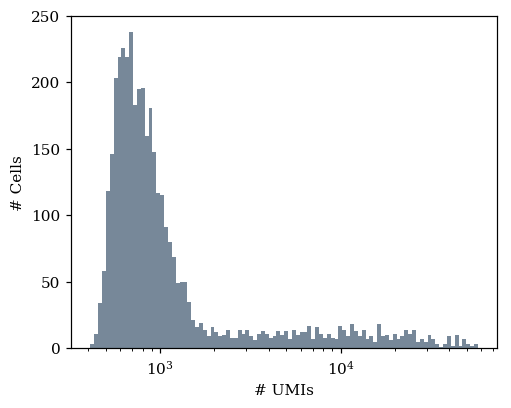

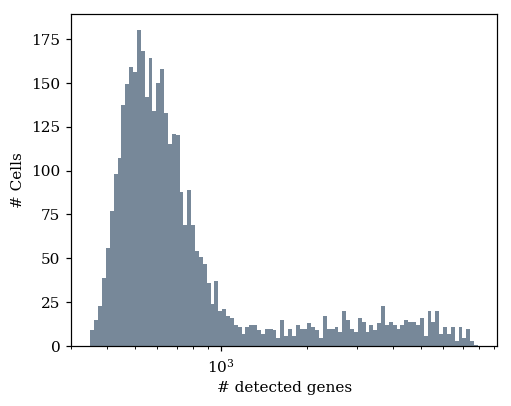

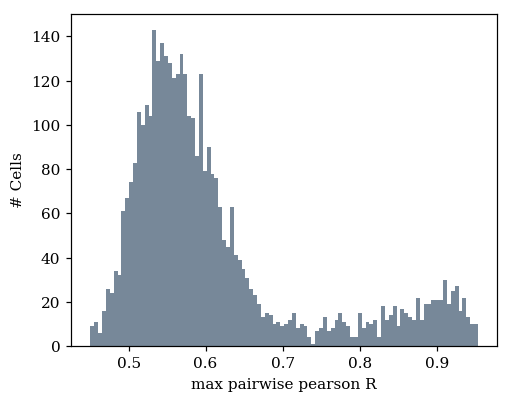

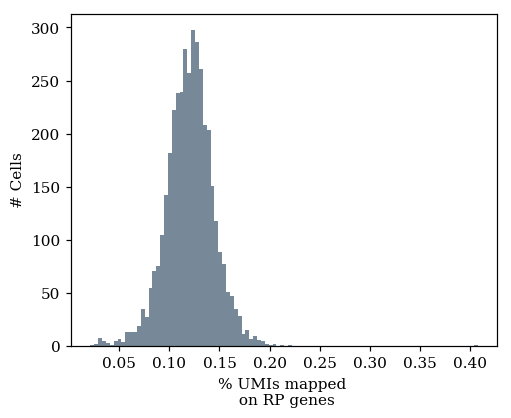

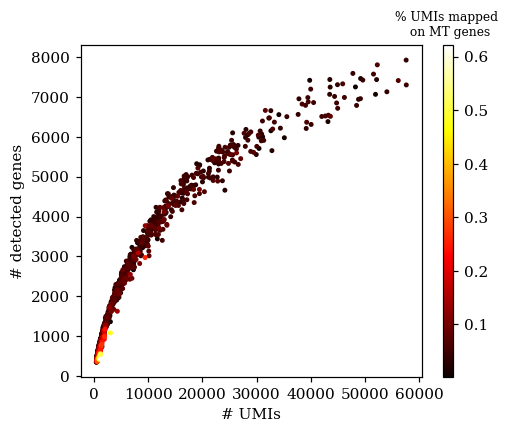

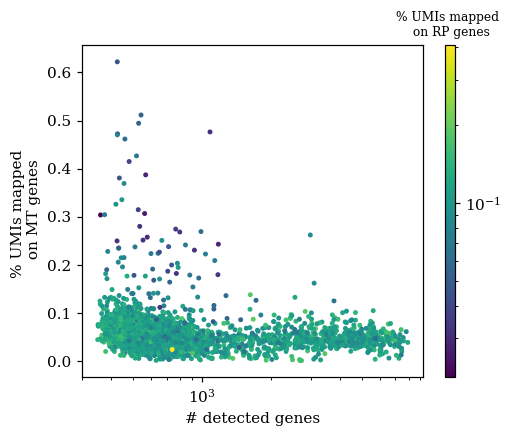

In [787]:
rnaseq.pp.plot_qc(sc, show_cutoffs=False)

In [301]:
sc.X.shape

(3935, 60240)

In [259]:
sc.X.shape

(3794, 20305)

In [565]:
rnaseq.annot.annotate_genes(sc, "gene_biotype")

Annotating gene_biotype using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


In [566]:
sc._inplace_subset_var(sc.var["gene_biotype"] == "protein_coding")

In [562]:
adata_pp = sc.copy() ###
scanpy.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6) ###
scanpy.pp.log1p(adata_pp) ###
scanpy.pp.pca(adata_pp, n_comps=15) ###
scanpy.pp.neighbors(adata_pp) ###
scanpy.tl.louvain(adata_pp, key_added='groups', resolution=0.5) ###

#Preprocess variables for scran normalization ###
input_groups = adata_pp.obs['groups'] ###
data_mat = sc.X.toarray().T ###

del adata_pp

In [560]:
%load_ext rpy2.ipython

In [563]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find

In [568]:
sc.obs['size_factors'] = size_factors
sc.X /= sc.obs['size_factors'].values[:,None]

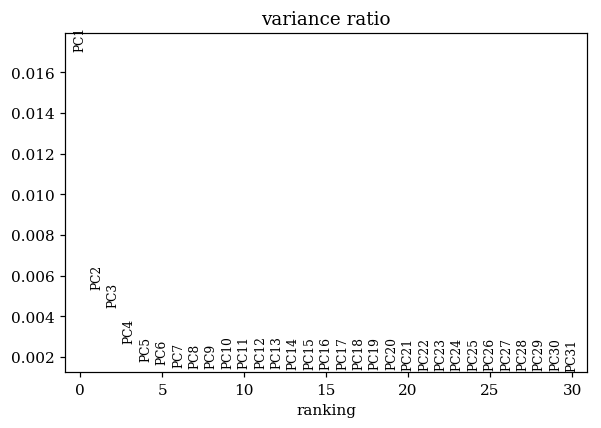

In [569]:


# scanpy.pp.normalize_total(sc, exclude_highly_expressed=True)
scanpy.pp.log1p(sc)



# rnaseq.pp.log_norm(sc)
scanpy.pp.pca(sc, use_highly_variable=False)
scanpy.pl.pca_variance_ratio(sc, n_pcs=30)

... storing 'samples' as categorical
... storing 'project_id' as categorical
... storing 'cell_lines' as categorical
... storing 'source' as categorical
... storing 'chromosome_name' as categorical
... storing 'external_gene_name' as categorical
... storing 'gene_biotype' as categorical


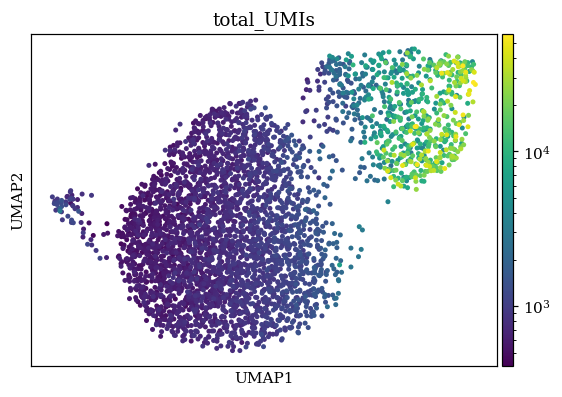

In [570]:
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors = 100)
scanpy.tl.umap(sc)
scanpy.pl.umap(sc, color = "total_UMIs", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

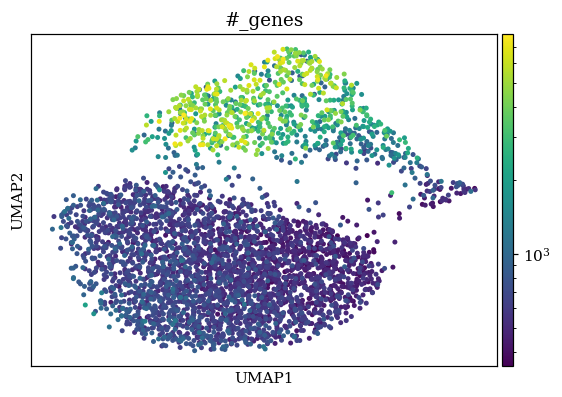

In [447]:
scanpy.pl.umap(sc, color = "#_genes", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

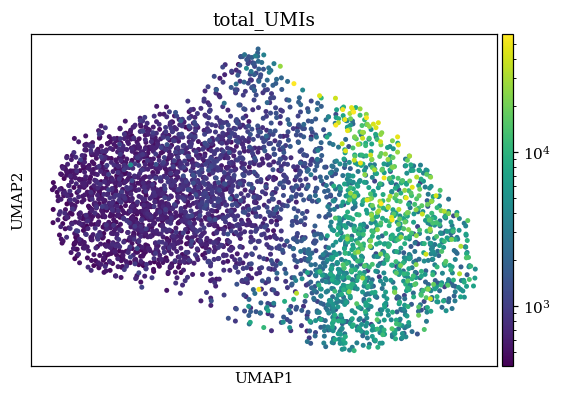

In [262]:
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors = 100)
scanpy.tl.umap(sc)
scanpy.pl.umap(sc, color = "total_UMIs", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

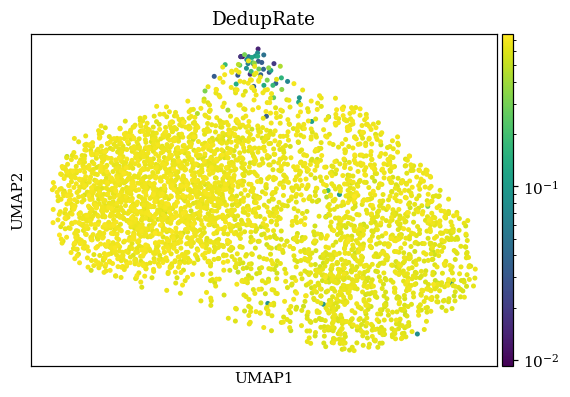

In [263]:
scanpy.pl.umap(sc, color = "DedupRate", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

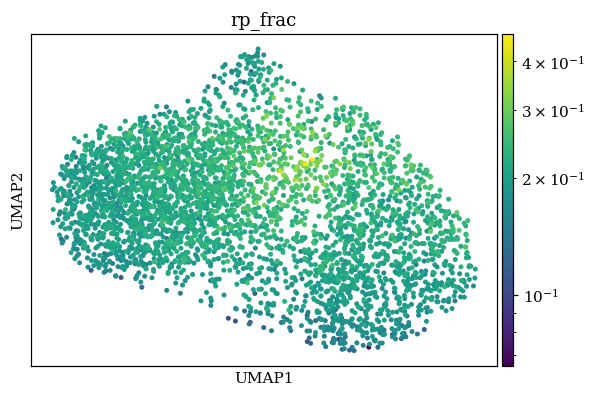

In [170]:
scanpy.pl.umap(sc, color = "rp_frac", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

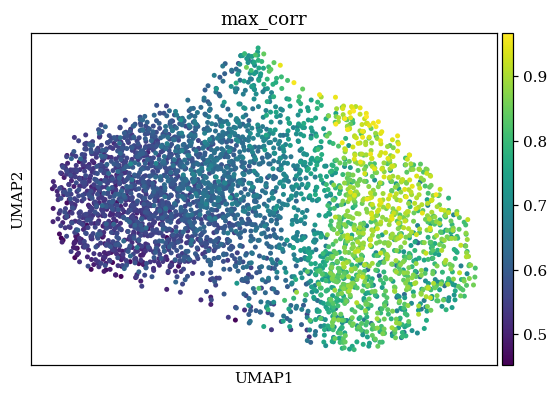

In [171]:
scanpy.pl.umap(sc, color = "max_corr", gene_symbols="external_gene_name", use_raw=False, s = 43)

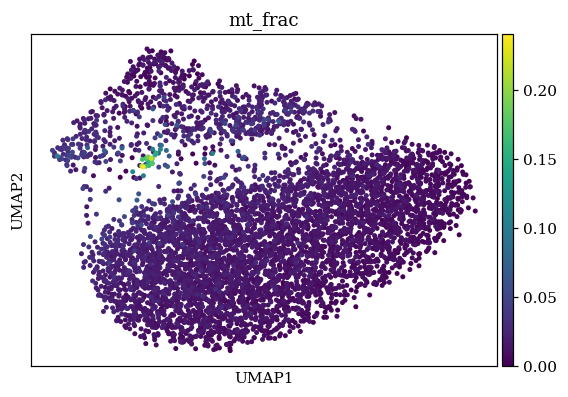

In [206]:
scanpy.pl.umap(sc, color = "mt_frac", gene_symbols="external_gene_name", use_raw=False, s = 43)

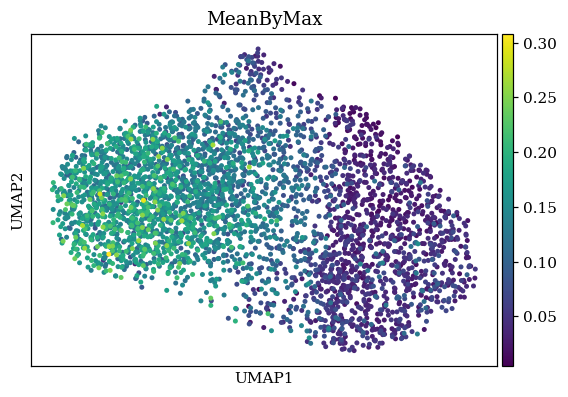

In [264]:
scanpy.pl.umap(sc, color = "MeanByMax", gene_symbols="external_gene_name", use_raw=False, s = 43)

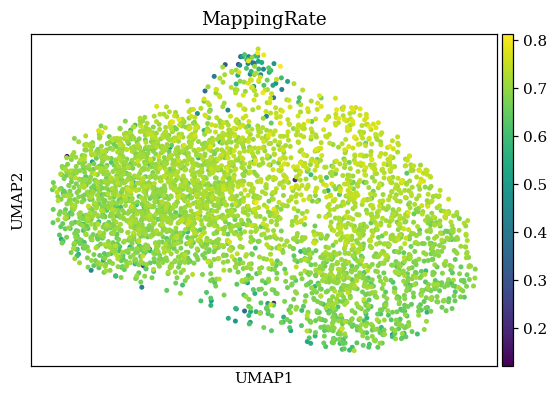

In [265]:
scanpy.pl.umap(sc, color = "MappingRate", gene_symbols="external_gene_name", use_raw=False, s = 43)

### Stringent filtering

__QC before filtering__

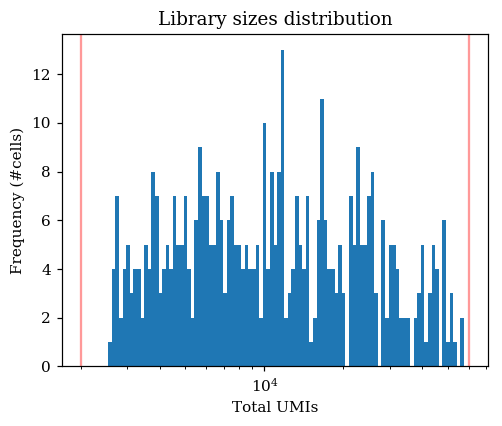

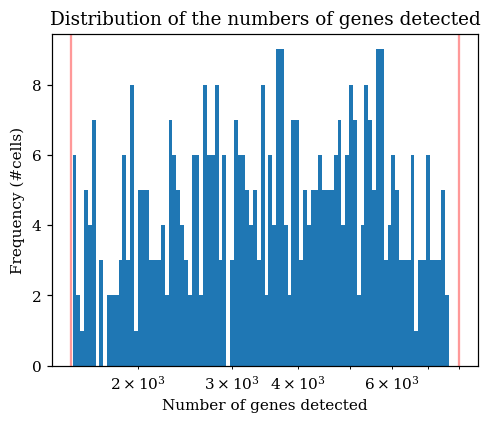

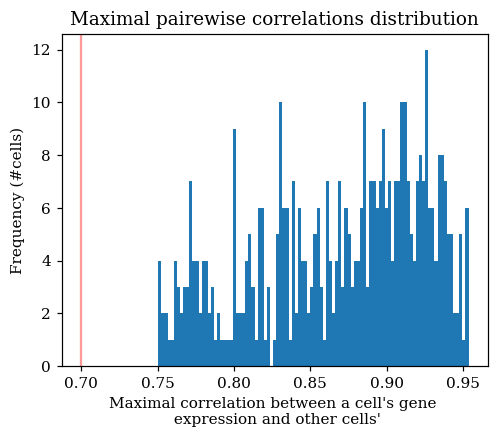

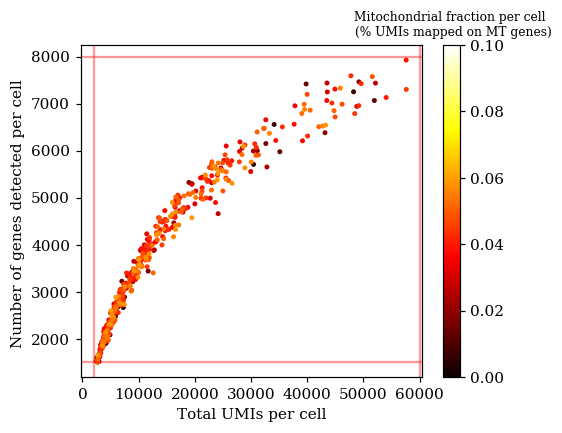

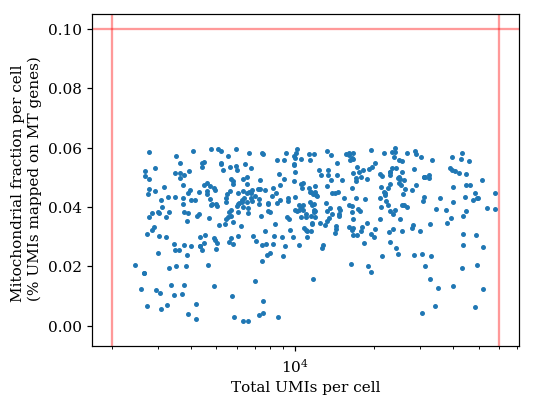

In [329]:
rnaseq.pp.plot_qc(sc, n_counts_max=60000, n_counts_min = 2000, n_genes_max=8000, n_genes_min = 1500, mt_max = 0.1, max_corr_thr = 0.7)

__Filtering cells__

In [428]:
rnaseq.pp.filter_cells(sc,  n_counts_max=60000, n_counts_min = 2000, n_genes_max=8000, n_genes_min = 1500, mt_max = 0.1, max_corr_thr = 0.75, inplace = True)

In [429]:
sc.X.shape
# sc.obs["keep"].sum()

(553, 60240)

__QC after filtering__

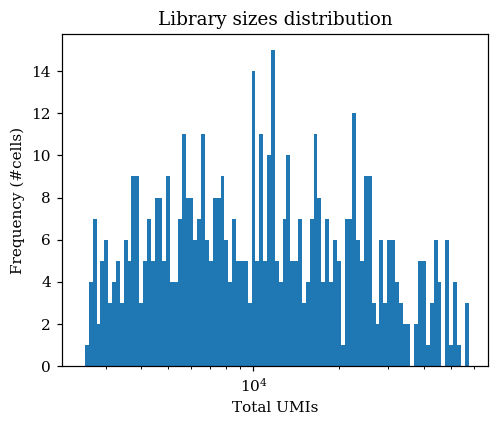

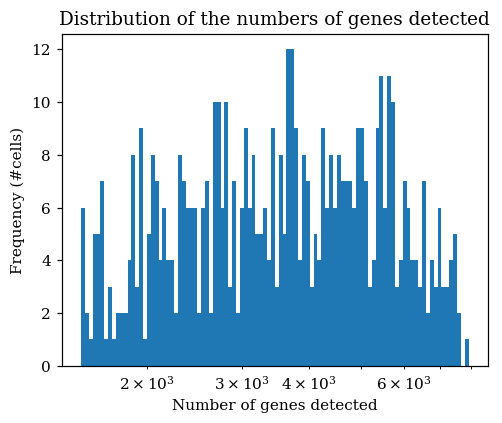

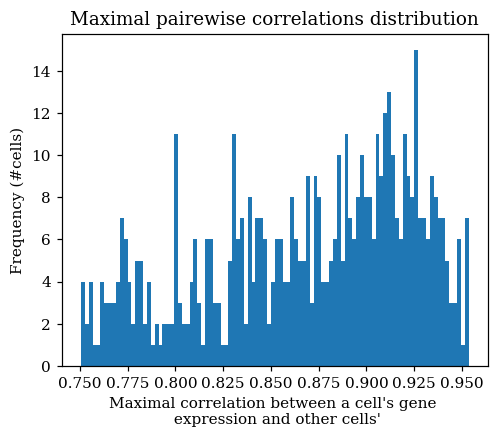

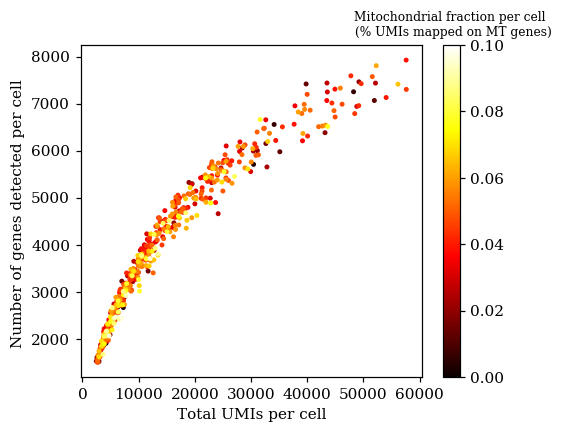

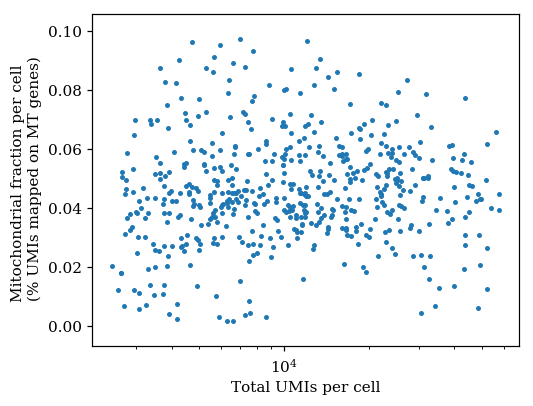

In [430]:
rnaseq.pp.plot_qc(sc, show_cutoffs=False)

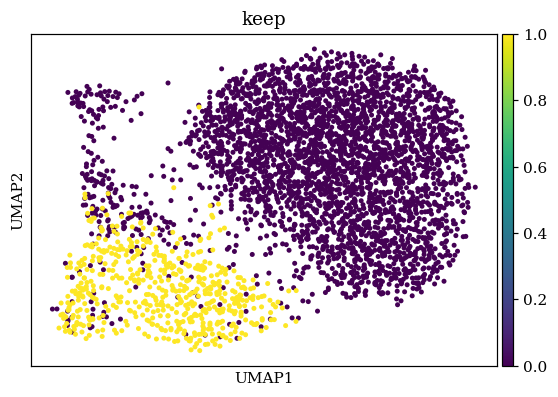

In [337]:
scanpy.pl.umap(sc, color = "keep", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [280]:
sc._inplace_subset_obs(sc.obs["keep"])

In [114]:
sc.save_layer()

In [67]:
sc.log_norm()
sc.load_layer("raw")

Normalization by total UMIs...
Log2 + 1 tranformation...


In [68]:
sc.layers

Layers with keys: log_norm, raw

### Filtering with louvain

__Filtering cells__

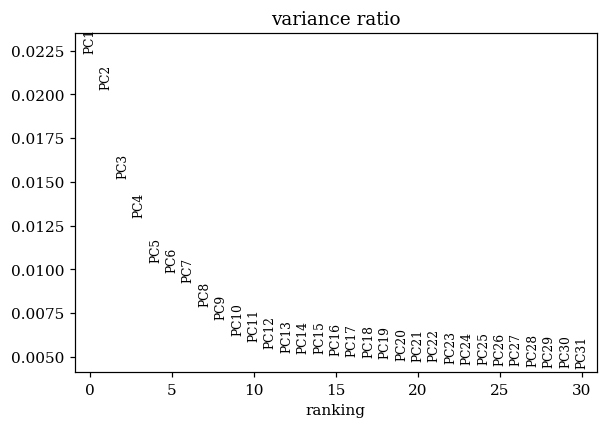

In [748]:
# scanpy.pp.normalize_total(sc, exclude_highly_expressed=True)
# scanpy.pp.log1p(sc)
# rnaseq.pp.log_norm(sc)
scanpy.pp.pca(sc, use_highly_variable=False)
scanpy.pl.pca_variance_ratio(sc, n_pcs=30)

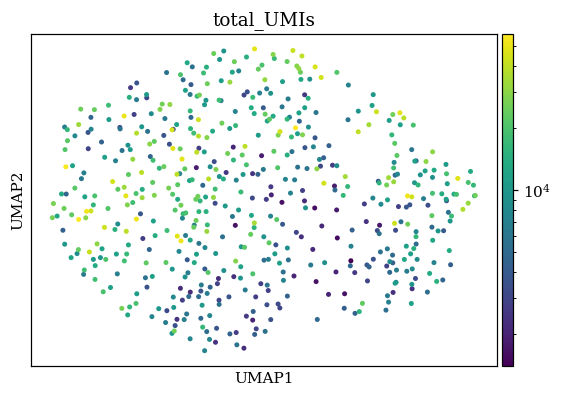

In [760]:
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors = 100)
scanpy.tl.umap(sc, spread=2)
scanpy.pl.umap(sc, color = "total_UMIs", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

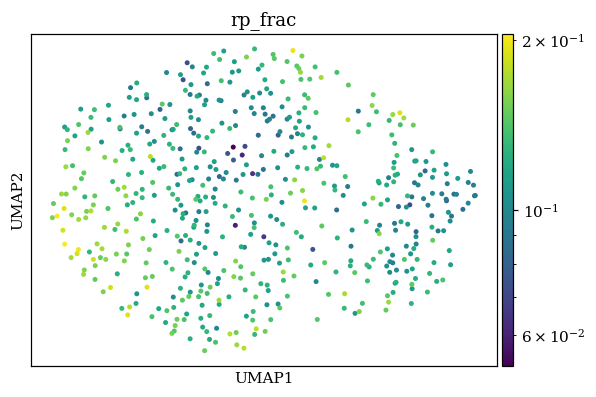

In [761]:
scanpy.pl.umap(sc, color = "rp_frac", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

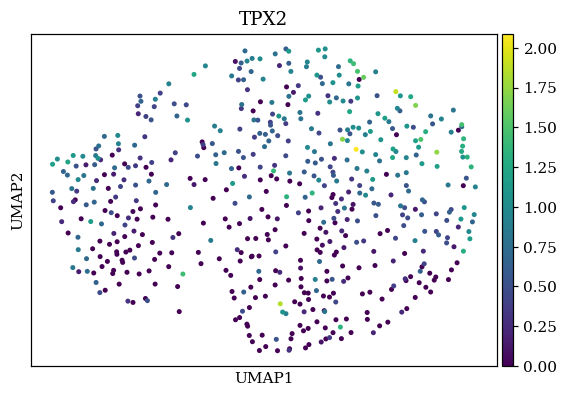

In [750]:
scanpy.pp.neighbors(sc, n_pcs=20, n_neighbors = 80)
scanpy.tl.umap(sc, spread=3)
scanpy.pl.umap(sc, color = "TPX2", gene_symbols="external_gene_name", use_raw=False, s = 43)

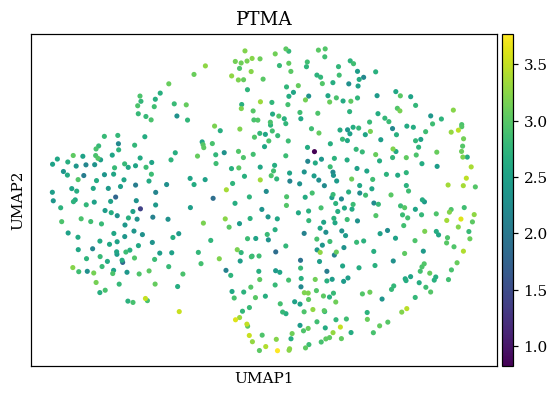

In [751]:
scanpy.pl.umap(sc, color = "PTMA", gene_symbols="external_gene_name", use_raw=False, s = 45)

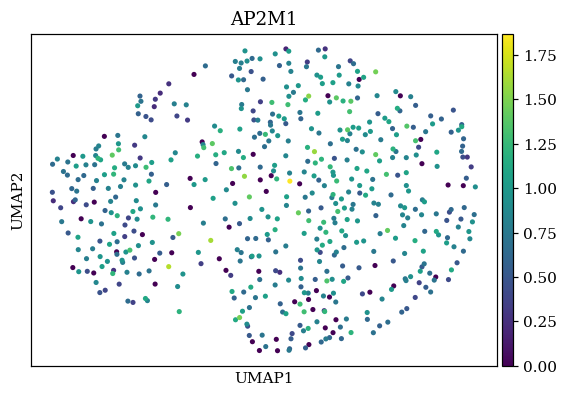

In [752]:
scanpy.pl.umap(sc, color = "AP2M1", gene_symbols="external_gene_name", use_raw=False, s = 45)

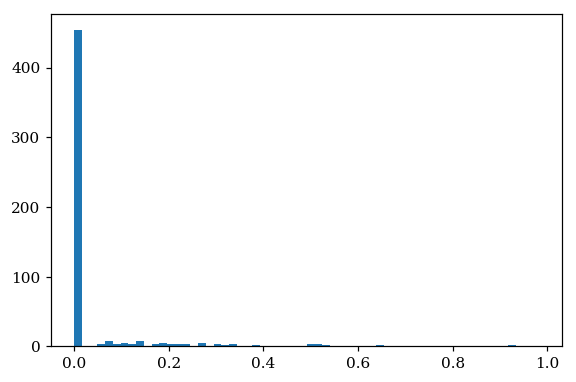

In [734]:
plt.hist(sc.X.toarray()[~(sc.obs["louvain"]=="1"), sc.var["external_gene_name"] == "ALDH1A1"], bins=60);

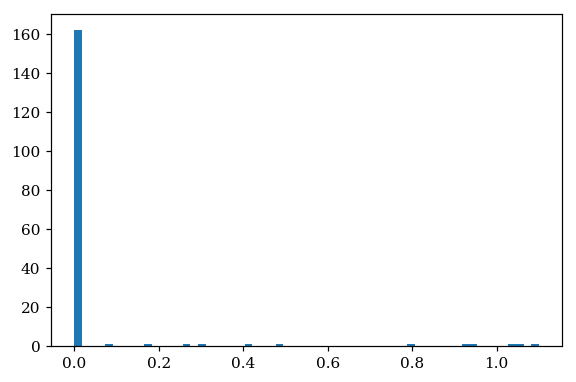

In [735]:
plt.hist(sc.X.toarray()[(sc.obs["louvain"]=="1"), sc.var["external_gene_name"] == "ALDH1A1"], bins=60);

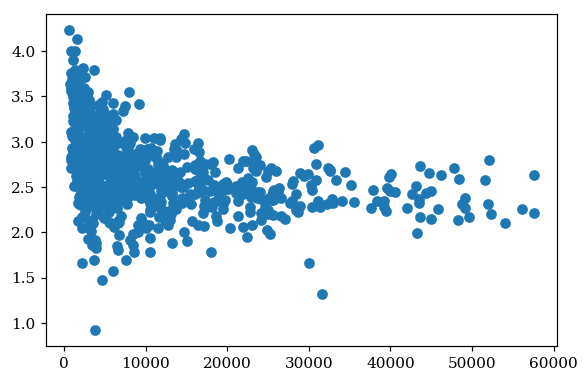

In [722]:
plt.scatter(sc.obs["total_UMIs"], sc.X.toarray()[:, sc.var["external_gene_name"] == "HSP90AA1"])

In [753]:
sc.var_names_make_unique()
cell_cycle_genes = np.array(['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG',
       'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'HELLS', 'RFC2',
       'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2',
       'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6',
       'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN',
       'POLA1', 'CHAF1B', 'BRIP1', 'E2F8', 'HMGB2', 'CDK1', 'NUSAP1',
       'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2',
       'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'SMC4', 'CCNB2',
       'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B',
       'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'CDC20', 'TTK', 'CDC25C',
       'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2',
       'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE',
       'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA'])

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
scanpy.tl.score_genes_cell_cycle(sc, s_genes = s_genes, g2m_genes=g2m_genes)

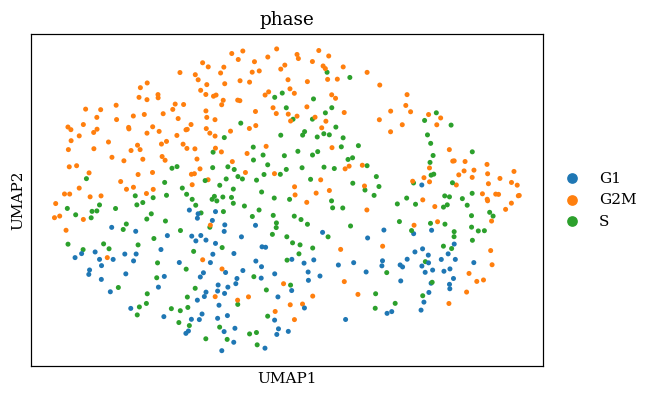

In [762]:
scanpy.pl.umap(sc, color = "phase", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [575]:
from scipy.sparse import csr_matrix
sc.X = csr_matrix(sc.X)

In [769]:
scanpy.tl.louvain(sc, resolution = 0.6)

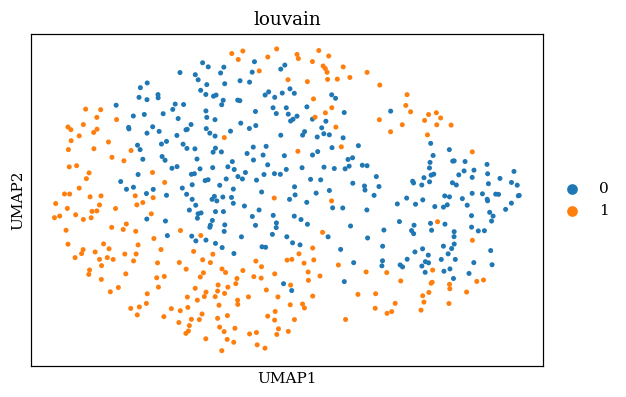

In [770]:
scanpy.pl.umap(sc, color = "louvain", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [747]:
sc._inplace_subset_obs(~(sc.obs["louvain"] == "1"))

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
sc._inplace_subset_var(~np.array([s.startswith("RP") for s in sc.var_names]))

/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/dea.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = pd.DataFrame(np.array(data[gene_set_library])[:,1:], columns=["Term", "P-value", "Z-score", "Combined Score", "Genes", "Adjusted P-value", "Old P-value", "Old adjusted P-value"])
/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous 

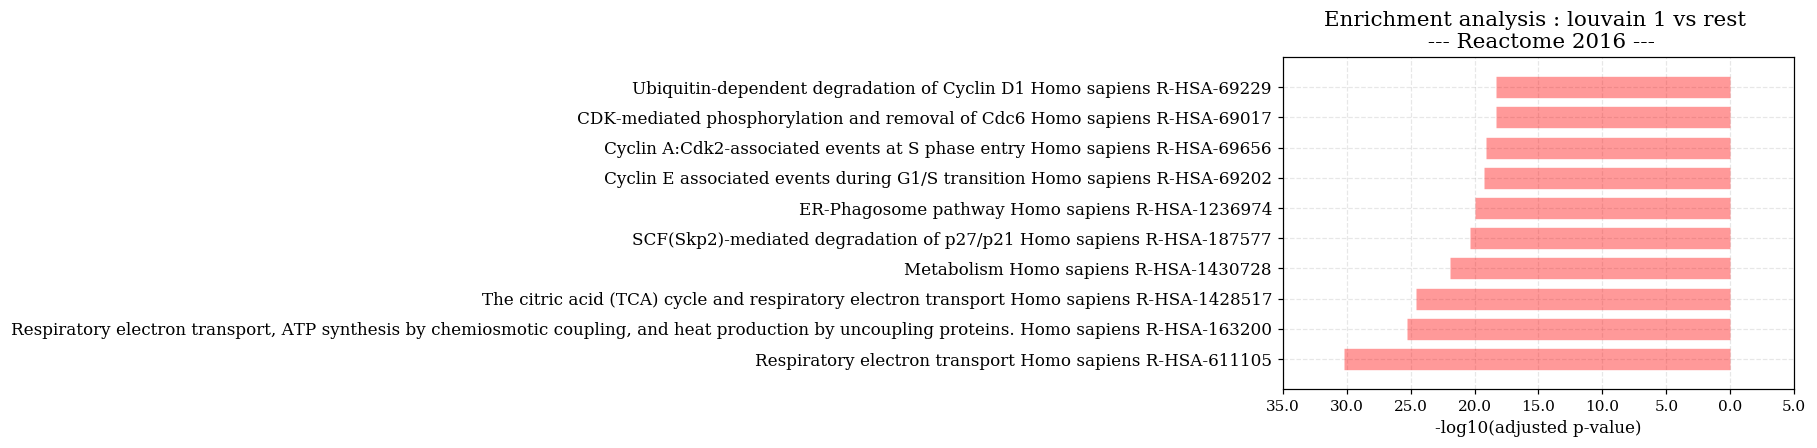

index                                               Term      P-value  \
0      0  Respiratory electron transport Homo sapiens R-...  5.60395e-34   
1      1  Respiratory electron transport, ATP synthesis ...   9.7139e-29   
2      2  The citric acid (TCA) cycle and respiratory el...  7.07351e-28   
3      3              Metabolism Homo sapiens R-HSA-1430728  4.72946e-25   
4      4  SCF(Skp2)-mediated degradation of p27/p21 Homo...  2.09901e-23   
5      5    ER-Phagosome pathway Homo sapiens R-HSA-1236974  5.76427e-23   
6      6  Cyclin E associated events during G1/S transit...  3.42833e-22   
7      7  Cyclin A:Cdk2-associated events at S phase ent...  6.04992e-22   
8      8  CDK-mediated phosphorylation and removal of Cd...  5.66476e-21   
9      9  Ubiquitin-dependent degradation of Cyclin D1 H...  5.66476e-21   

   Z-score Combined Score                                              Genes  \
0  18.8575        1443.82  [NDUFB9, COX7B, NDUFB8, NDUFB6, NDUFB10, NDUFA...   
1  12.5577        809.987  [NDUFB9, COX7B, NDUFB8, NDUFB10, NDUFB6, NDUFA...   
2  9.15592        572.392  [COX7B, NDUFA12, ETFA, COX6A1, COX7C, MPC2, ID...   
3  2.42018        135.556  [CDA, MT1X, NUDT5, PSMD8, GCSH, PNP, PSMD4, SC...   
4  18.8184        982.661  [PSMD10, CDKN1A, PSMD14, CKS1B, PSMD8, PSMB6, ...   
5  16.4927        844.556  [PSMD10, PSMD14, PSMD8, PSMB6, PSMB7, PSMB4, P...   
6  15.1159        747.102  [PSMD10, CDKN1A, PSMD14, CKS1B, PSMD8, PSMB6, ...   
7  14.7066        718.518  [PSMD10, CDKN1A, PSMD14, CKS1B, PSMD8, PSMB6, ...   
8  19.8868        927.125  [PSMD10, PSMD14, PSMD8, PSMB6, PSMB7, PSMB4, P...   
9  19.8868        927.125  [PSMD10, PSMD14, PSMD8, PSMB6, PSMB7, PSMB4, P...   

   Adjusted P-value Old P-value Old adjusted P-value color  
0        -30.213681           0                    0   red  
1        -25.275811           0                    0   red  
2        -24.589662           0                    0   red  
3        -21.889424           0                    0   red  
4        -20.339132           0                    0   red  
5        -19.979582           0                    0   red  
6        -19.272191           0                    0   red  
7        -19.083516           0                    0   red  
8        -18.352234           0                    0   red  
9        -18.352234           0                    0   red

In [711]:
rnaseq.dea.enrichr(sc, group = "1", libraries=["Reactome_2016"], lfc_cutoff=0.5)

In [588]:
# sc._inplace_subset_obs(sc.obs["louvain"] == '3')

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [744]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="louvain", groups = ["0"], reference = "rest", method = "t-test_overestim_var", n_genes=2000, rankby_abs=True)

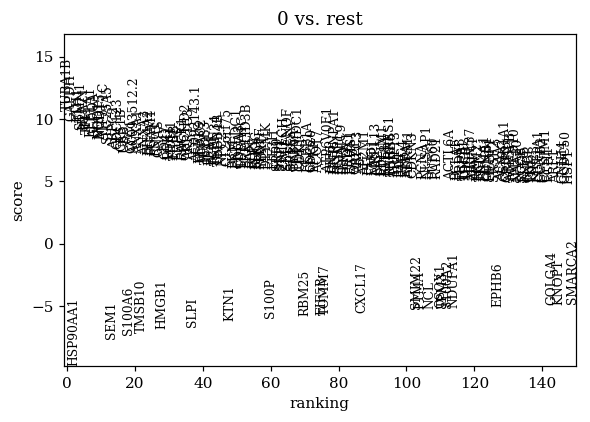

In [745]:
scanpy.pl.rank_genes_groups(sc, gene_symbols="external_gene_name", n_genes=150)

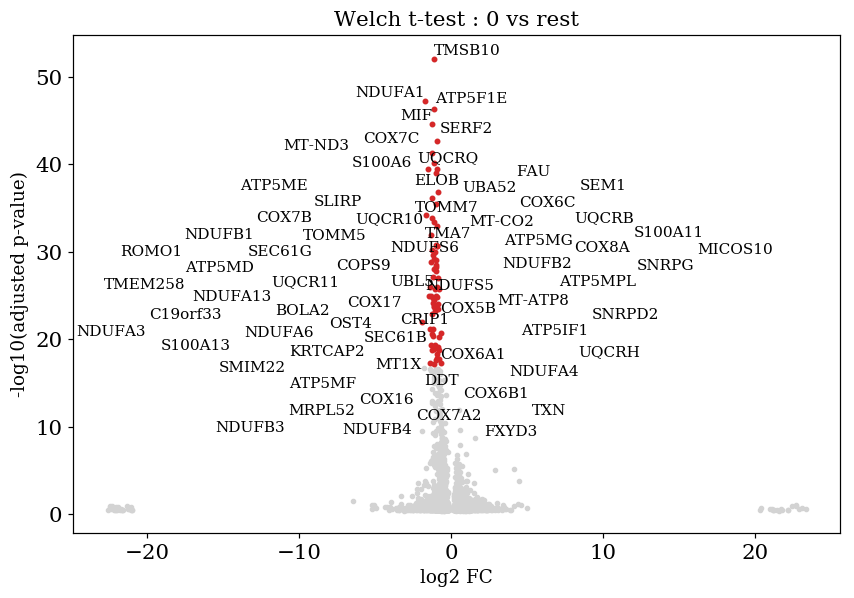

In [688]:
rnaseq.dea.volcano_plot(sc, group = "0", top=70)

In [141]:
rnaseq.dea.enrichr(sc, group = "1")

Genes_Associated_with_NIH_Grants
Cancer_Cell_Line_Encyclopedia
Achilles_fitness_decrease
Achilles_fitness_increase
Aging_Perturbations_from_GEO_down
Aging_Perturbations_from_GEO_up
Allen_Brain_Atlas_10x_scRNA_2021
Allen_Brain_Atlas_down
Allen_Brain_Atlas_up
ARCHS4_Cell-lines
ARCHS4_IDG_Coexp
ARCHS4_Kinases_Coexp
ARCHS4_TFs_Coexp
ARCHS4_Tissues
BioCarta_2013
BioCarta_2015
BioCarta_2016
BioPlanet_2019
BioPlex_2017
CCLE_Proteomics_2020
CellMarker_Augmented_2021
ChEA_2013
ChEA_2015
ChEA_2016
Chromosome_Location
Chromosome_Location_hg19
ClinVar_2019
CORUM
COVID-19_Related_Gene_Sets
COVID-19_Related_Gene_Sets_2021
Data_Acquisition_Method_Most_Popular_Genes
dbGaP
DepMap_WG_CRISPR_Screens_Broad_CellLines_2019
DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
Descartes_Cell_Types_and_Tissue_2021
Disease_Perturbations_from_GEO_down
Disease_Perturbations_from_GEO_up
Disease_Signatures_from_GEO_down_2014
Disease_Signatures_from_GEO_up_2014
DisGeNET
Drug_Perturbations_from_GEO_2014
Drug_Perturbations_

In [319]:
# sc._inplace_subset_obs(sc.obs["keep"])

### scvi

In [628]:
import scvi
import copy

In [631]:
sc._inplace_subset_var(sc.var["highly_variable"])
sc.load_layer("raw")
scvi.data.setup_anndata(sc)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


KeyError: 'raw'

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
INFO     Training for 100 epochs                                                             
INFO     KL warmup for 100 epochs                                                            
Training...:   2%|▏         | 2/100 [00:00<00:06, 14.38it/s]

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/scvi/core/distributions/_negative_binomial.py:434: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Training...: 100%|██████████| 100/100 [00:05<00:00, 19.42it/s]
INFO     Training time:  3 s. / 100 epochs                                                   
           Train         Test
0    1006.071644   950.278348
1     909.099112   861.392578
2    1084.449990  1023.959263
3    1249.965391  1161.833259
4     866.947129   815.558817
..           ...          ...
96    649.102844   638.320536
97    649.465055   638.973661
98    648.509318   638.162277
99    649.182399   638.139230
100   647.875411   638.287723

[101 rows x 2 columns]


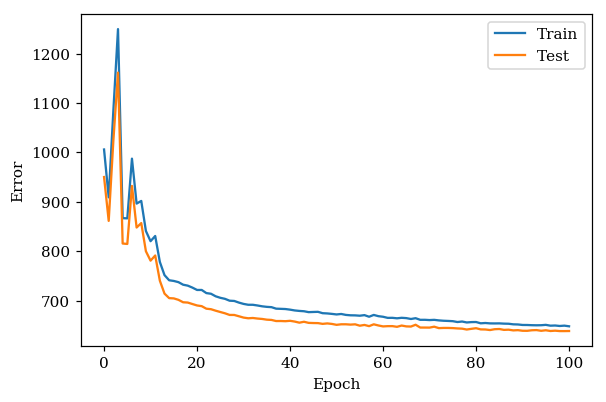

In [128]:
model = scvi.model.SCVI(sc, n_hidden=32, n_layers = 1, n_latent = 10)

# MODEL TRAINING
model.train(frequency=1,
            lr = 0.005,
            n_epochs_kl_warmup = 100,
            n_epochs = 100)



train_test_results = pd.DataFrame(model.trainer.history).rename(columns={'elbo_train_set':'Train', 'elbo_test_set':'Test'})
print(train_test_results)

ax = train_test_results.plot()
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")
plt.show()

In [129]:
sc.obsm["X_scvi"] = model.get_latent_representation()

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


### Final rep

Normalization by total UMIs...
Log2 + 1 tranformation...


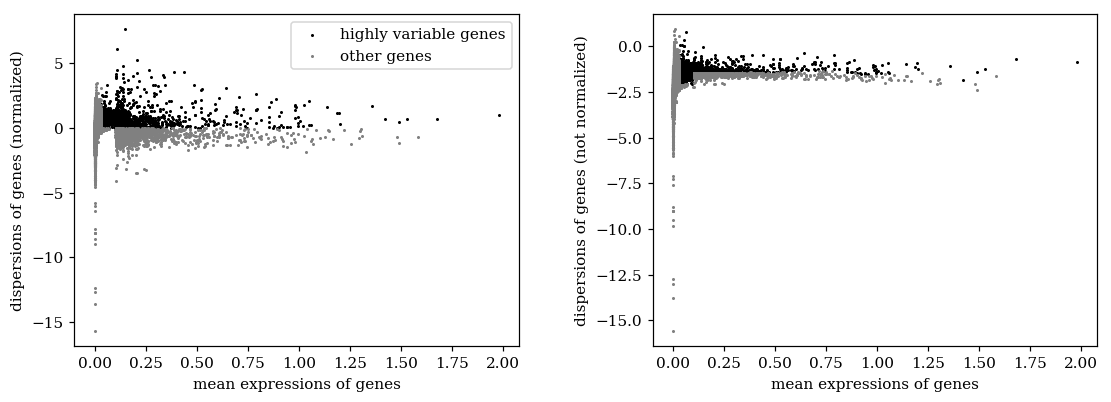

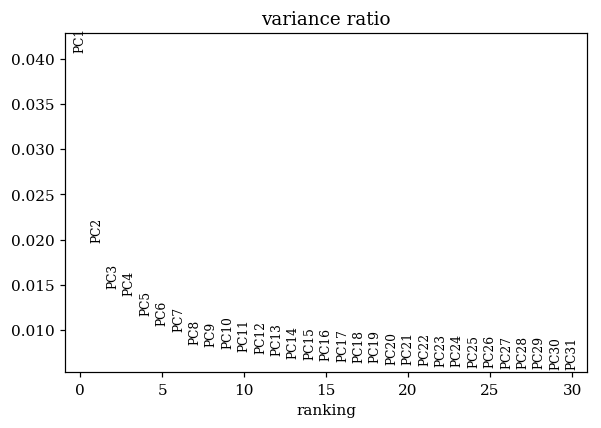

In [507]:
rnaseq.pp.log_norm(sc)

scanpy.pp.highly_variable_genes(sc, min_disp=0, min_mean=0.03)
scanpy.pl.highly_variable_genes(sc)

scanpy.pp.pca(sc, use_highly_variable=True)
scanpy.pl.pca_variance_ratio(sc)

In [251]:
np.sum(sc.var["highly_variable"])

2080

In [592]:
sc.annotate_genes("gene_biotype")
sc._inplace_subset_var(sc.var["gene_biotype"] == "protein_coding")
x = np.corrcoef(sc.obsm["X_pca"].T[1], sc.X.toarray().T)[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


gene_biotype already annotated. Set ow = True if you want to overwrite.


/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [596]:
sc.var_names[np.argsort(-np.abs(x[1:]))][:100]

Index(['TMSB10', 'ATP5F1E', 'RPS29', 'RPS21', 'RPS28', 'RPL37A', 'RPL39',
       'RPL22', 'RPL37', 'CRIP1', 'SERF2', 'RPLP2', 'RPL36A', 'RPL21', 'RPL35',
       'RPL38', 'RPL36', 'RPL34', 'RPS27', 'RPL41', 'S100A6', 'GAPDH', 'COX6C',
       'ALDOA', 'NDUFA1', 'RPL35A', 'PTMA', 'RPS8', 'RPS24', 'AC093512.2',
       'UQCRQ', 'TPI1', 'TOMM7', 'RPLP1', 'RPS19', 'NDUFB1', 'SEM1', 'RPL23',
       'ROMO1', 'RPS12', 'RPS17', 'UQCRB', 'UBB', 'RPL31', 'ANXA2', 'RPS20',
       'RPL32', 'RPL27A', 'FTH1', 'TUBA1B', 'ATP5MD', 'EEF1G', 'KLK5', 'COPS9',
       'SELENOF', 'NDUFS6', 'SLC25A5', 'RPL24', 'RPLP0', 'ANXA1', 'ELOB',
       'KRT19', 'H2AZ1', 'RPL3', 'RPS15', 'RPL27', 'MT1X', 'ECH1', 'C19orf33',
       'RPS16', 'FTL', 'TACSTD2', 'AKR1B1', 'EEF1A1', 'S100A13', 'COX17',
       'ENO1', 'MIF', 'SMIM22', 'MYL12B', 'MZT2B', 'CYC1', 'ATP5ME', 'RPS25',
       'DSTN', 'RPL28', 'ATP5MPL', 'TMA7', 'SEC61G', 'TUBB', 'PKM', 'RPL12',
       'KRT18', 'SPINT2', 'CRABP2', 'PCBP1', 'CD9', 'ATP5MG', 'UBL5',
    

In [591]:
sc.X.shape

(734, 19904)

In [437]:
sc._inplace_subset_var(~np.array([s.startswith("RP") for s in sc.var_names]))

Dataset already log-normalized.


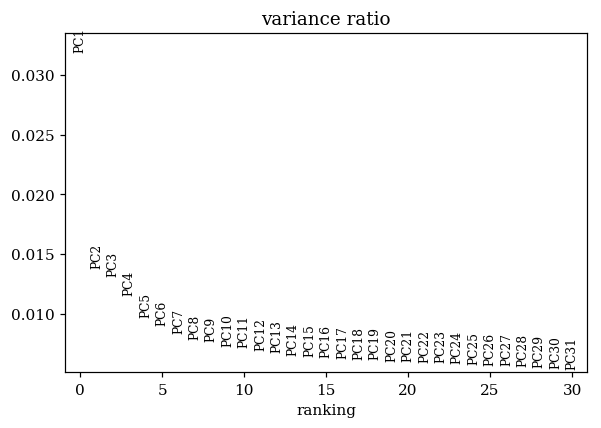

In [510]:
rnaseq.pp.log_norm(sc)
scanpy.pp.pca(sc, use_highly_variable=False)
scanpy.pl.pca_variance_ratio(sc, n_pcs=30)

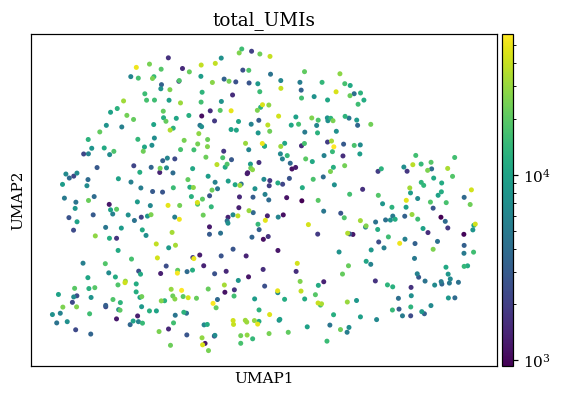

In [511]:
# sc._inplace_subset_var(sc.var["highly_variable"])
scanpy.pp.neighbors(sc, n_neighbors = 30, n_pcs = 30)
scanpy.tl.umap(sc, min_dist=0.5, spread=1)
scanpy.pl.umap(sc, color = "total_UMIs", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

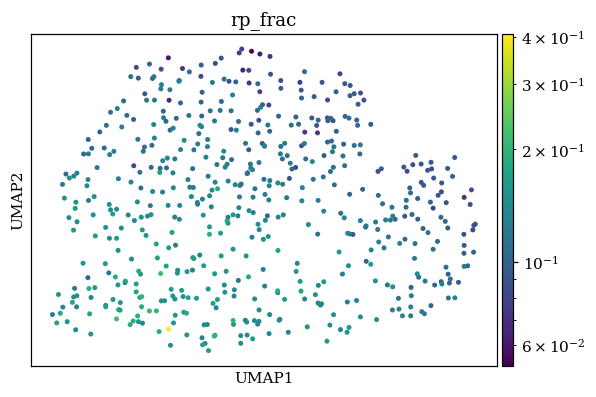

In [512]:
scanpy.pl.umap(sc, color = "rp_frac", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

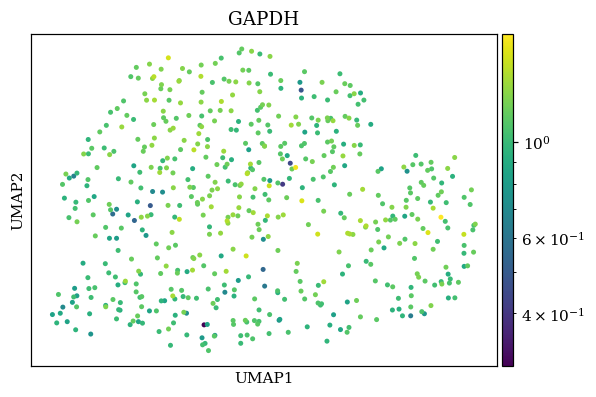

In [521]:
scanpy.pl.umap(sc, color = "GAPDH", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

In [522]:
sc.obs

index            CB  CorrectedReads  MappedReads  DeduplicatedReads  \
0         0  ACGACACGCTAA          208751       163012              57630   
2         2  GGCTTCGGCCCA          184013       143593              49596   
4         4  GATTGTTCTCGC          197294       151758              57599   
7         7  TCCGTCTATCTG          225709       182006              54042   
8         8  GATTGCGTAAAG          199661       155661              48451   
...     ...           ...             ...          ...                ...   
2506   2506  CGCCTATCTCAC            2584         1170               1162   
2648   2648  GAGTGCGCGCGA            2492         1141               1109   
2683   2683  GCCGCGCCATCT            2478         1612               1518   
3100   3100  GATTGGCGATTG            2279         1808               1464   
3147   3147  AAGTGCGCGCGA            2265         1297               1179   

      MappingRate  DedupRate  MeanByMax  NumGenesExpressed  NumGenesOverMean  \
0        0.780892   0.646468   0.008143               7304              1381   
2        0.780342   0.654607   0.008559               7429              1436   
4        0.769197   0.620455   0.006988               7926              1554   
7        0.806375   0.703076   0.012482               7133              1397   
8        0.779626   0.688740   0.008755               6790              1162   
...           ...        ...        ...                ...               ...   
2506     0.452786   0.006838   0.050614                883               167   
2648     0.457865   0.028046   0.071794                813               169   
2683     0.650525   0.058313   0.031977               1104               212   
3100     0.793330   0.190265   0.041533                743               197   
3147     0.572627   0.090979   0.076296                909               176   

      ...  samples  project_id cell_lines source    total_UMIs #_genes  \
0     ...    HCC70  old/dsp992      HCC70   labo  57630.000000    7303   
2     ...    HCC70  old/dsp992      HCC70   labo  49595.996094    7425   
4     ...    HCC70  old/dsp992      HCC70   labo  57599.000000    7926   
7     ...    HCC70  old/dsp992      HCC70   labo  54042.000000    7131   
8     ...    HCC70  old/dsp992      HCC70   labo  48451.000000    6789   
...   ...      ...         ...        ...    ...           ...     ...   
2506  ...    HCC70  old/dsp992      HCC70   labo   1162.000000     879   
2648  ...    HCC70  old/dsp992      HCC70   labo   1109.000000     811   
2683  ...    HCC70  old/dsp992      HCC70   labo   1518.000000    1100   
3100  ...    HCC70  old/dsp992      HCC70   labo   1464.000000     740   
3147  ...    HCC70  old/dsp992      HCC70   labo   1179.000000     908   

      max_corr   mt_frac   rp_frac  louvain  
0     0.953503  0.044671  0.169059        2  
2     0.940225  0.042906  0.130931        2  
4     0.952481  0.039259  0.120185        2  
7     0.938495  0.039728  0.156322        2  
8     0.953503  0.044785  0.190379        2  
...        ...       ...       ...      ...  
2506  0.667405  0.052567  0.116781        2  
2648  0.678249  0.019838  0.144939        2  
2683  0.708100  0.053689  0.074495        2  
3100  0.668957  0.024590  0.407861        2  
3147  0.679255  0.016964  0.182605        2  

[549 rows x 22 columns]

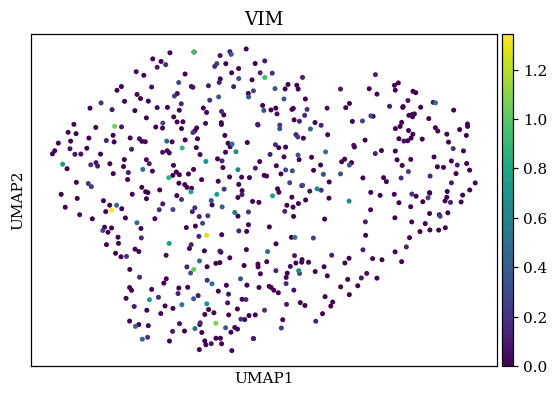

In [467]:
scanpy.pl.umap(sc, color = "VIM", gene_symbols="external_gene_name", use_raw=False, s = 43)

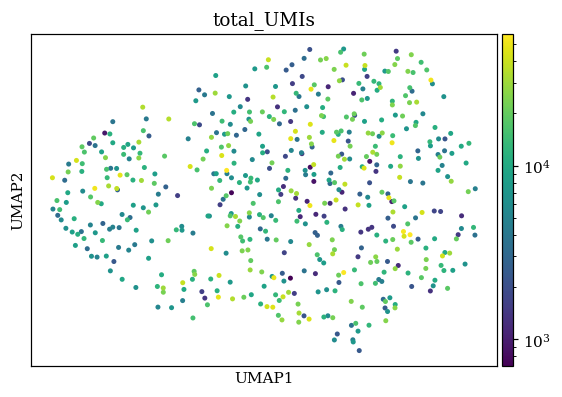

In [410]:
# sc._inplace_subset_var(sc.var["highly_variable"])
scanpy.pp.neighbors(sc, n_neighbors = 30, n_pcs = 30)
scanpy.tl.umap(sc, min_dist=0.5, spread=1)
scanpy.pl.umap(sc, color = "total_UMIs", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

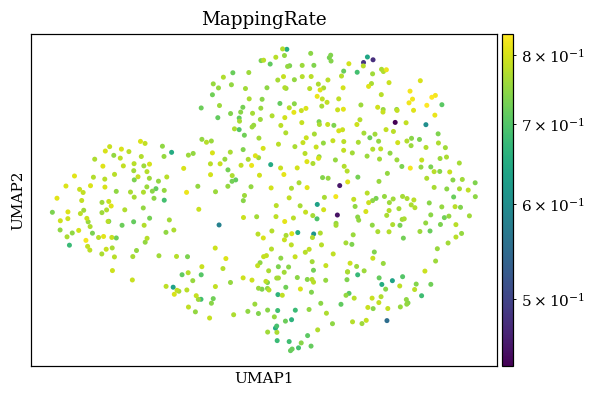

In [382]:
scanpy.pl.umap(sc, color = "MappingRate", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

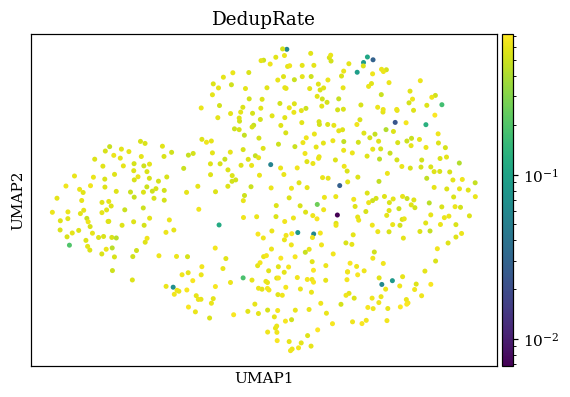

In [383]:
scanpy.pl.umap(sc, color = "DedupRate", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

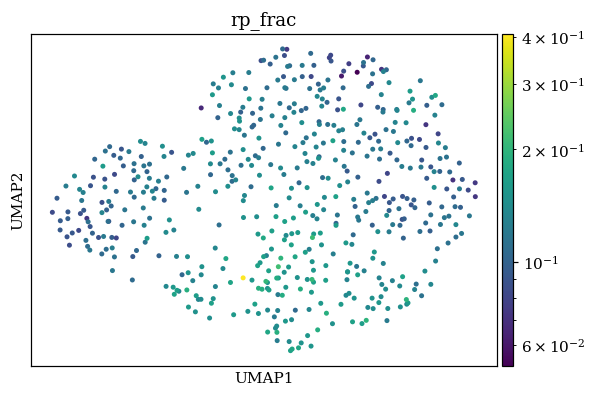

In [384]:
scanpy.pl.umap(sc, color = "rp_frac", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

In [470]:
scanpy.tl.louvain(sc, resolution = 0.4)

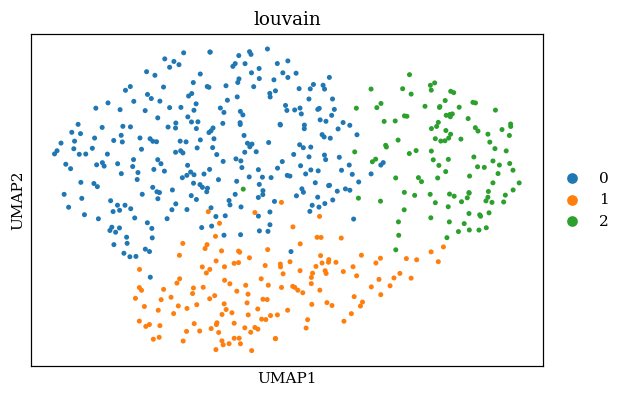

In [471]:
scanpy.pl.umap(sc, color = "louvain", gene_symbols="external_gene_name", use_raw=False, s = 43)

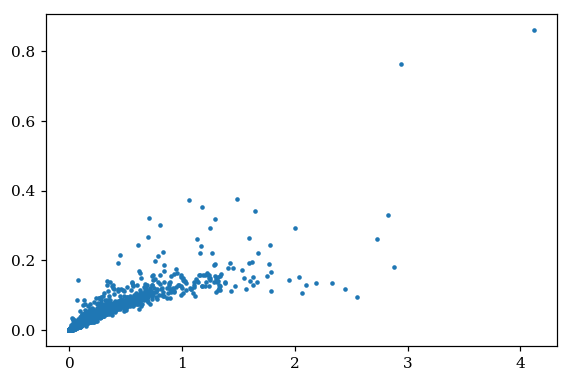

In [476]:
mean = sc.X.toarray()[sc.obs["louvain"] == "0"].mean(0)
var = sc.X.toarray()[sc.obs["louvain"] == "0"].var(0)

plt.scatter(mean, var, s=4)

In [688]:
sc._inplace_subset_obs(sc.obs["louvain"] == '0')

In [419]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="louvain", method = "t-test_overestim_var", n_genes=2000, rankby_abs=True)

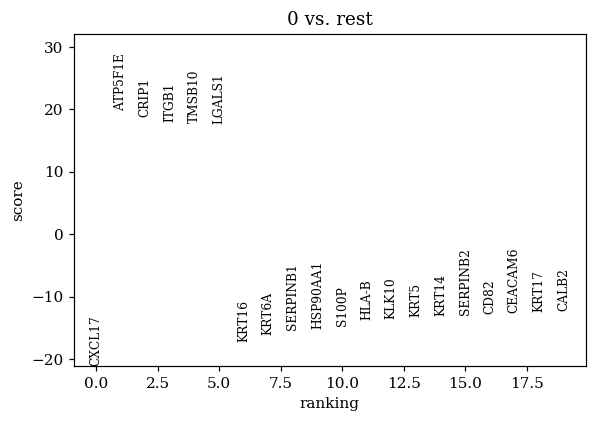

In [420]:
scanpy.pl.rank_genes_groups(sc, gene_symbols="external_gene_name", groups = ["0"], n_genes=20)

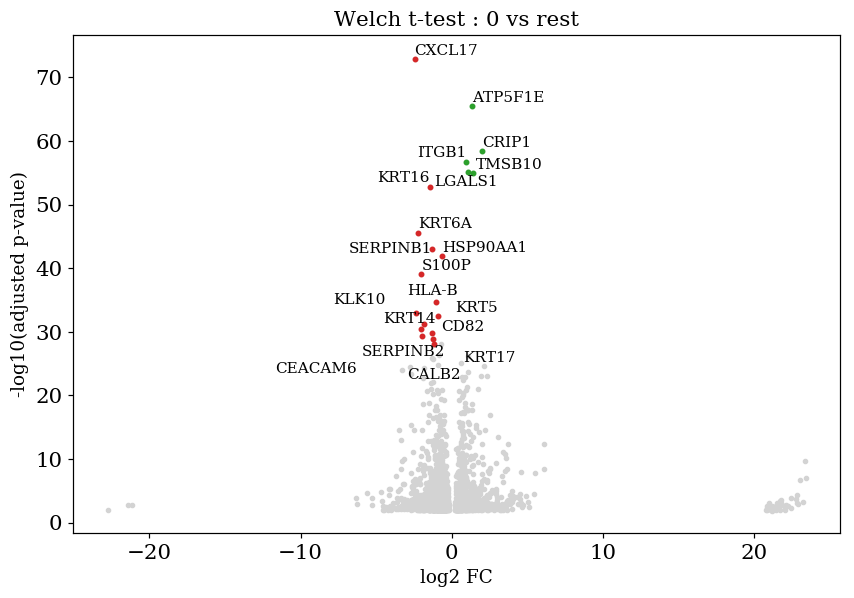

In [421]:
rnaseq.dea.volcano_plot(sc, group = "0")

/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/dea.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = pd.DataFrame(np.array(data[gene_set_library])[:,1:], columns=["Term", "P-value", "Z-score", "Combined Score", "Genes", "Adjusted P-value", "Old P-value", "Old adjusted P-value"])
/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous 

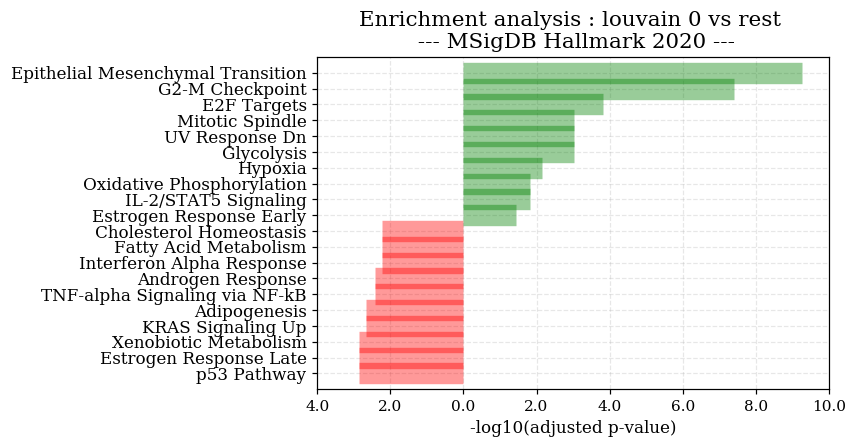

In [422]:
rnaseq.dea.enrichr(sc, group = "0", libraries=["MSigDB_Hallmark_2020"], lfc_cutoff=0.5)

In [689]:
sc.X.shape

(708, 60240)

Dataset already log-normalized.


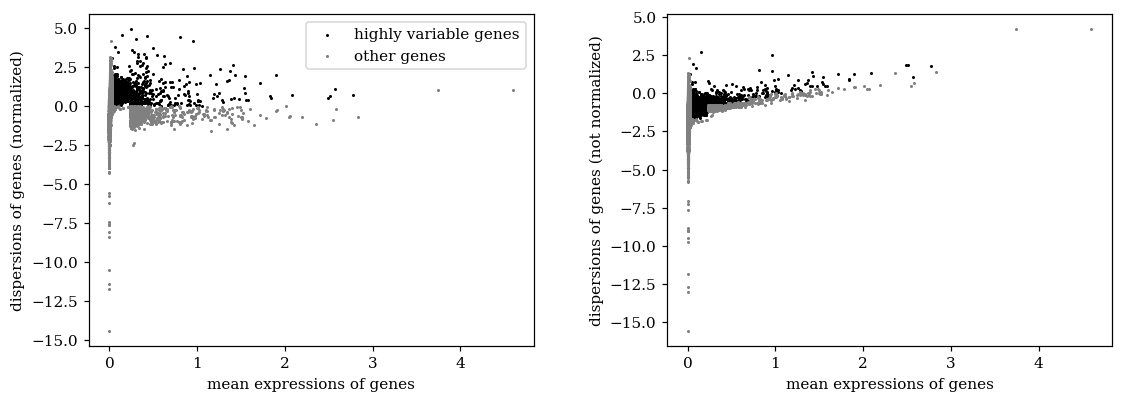

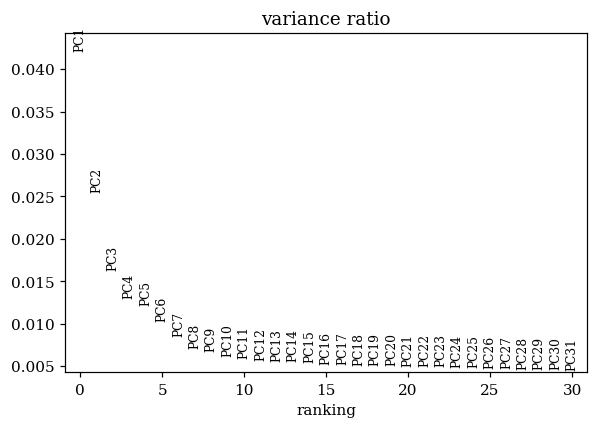

In [690]:
sc.log_norm()

scanpy.pp.highly_variable_genes(sc, min_disp=0, min_mean=0.03)
scanpy.pl.highly_variable_genes(sc)

scanpy.pp.pca(sc, use_highly_variable=True)
scanpy.pl.pca_variance_ratio(sc)

In [251]:
np.sum(sc.var["highly_variable"])

2080

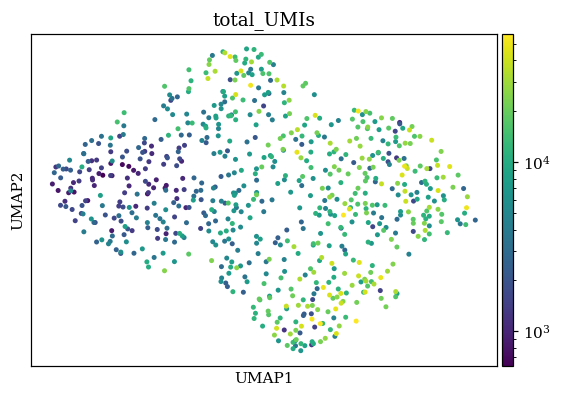

In [716]:
# sc._inplace_subset_var(sc.var["highly_variable"])
scanpy.pp.neighbors(sc, n_neighbors = 30, n_pcs = 10)
scanpy.tl.umap(sc, min_dist=0.5, spread=1.5)
scanpy.pl.umap(sc, color = "total_UMIs", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

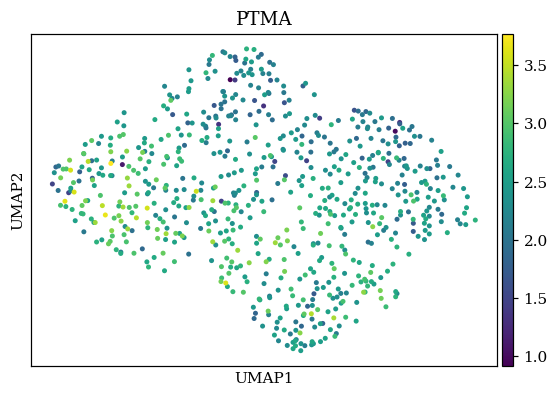

In [730]:
scanpy.pl.umap(sc, color = "PTMA", gene_symbols="external_gene_name", use_raw=False, s = 43)

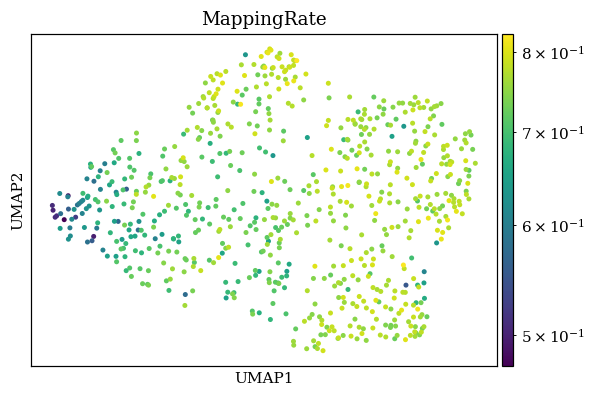

In [650]:
# sc._inplace_subset_var(sc.var["highly_variable"])
scanpy.pp.neighbors(sc, n_neighbors = 40, n_pcs = 8)
scanpy.tl.umap(sc, min_dist=0.3, spread=2)
scanpy.pl.umap(sc, color = "MappingRate", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

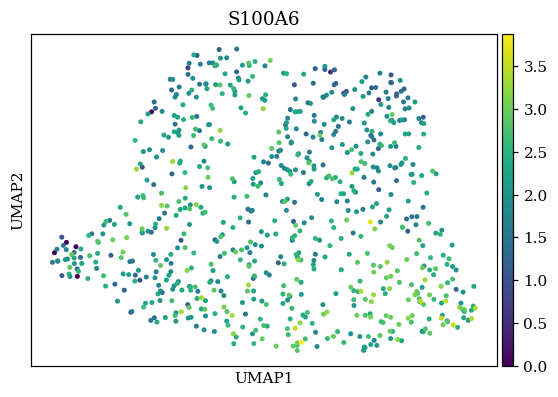

In [603]:
scanpy.pl.umap(sc, color = "S100A6", gene_symbols="external_gene_name", use_raw=False, s = 43)

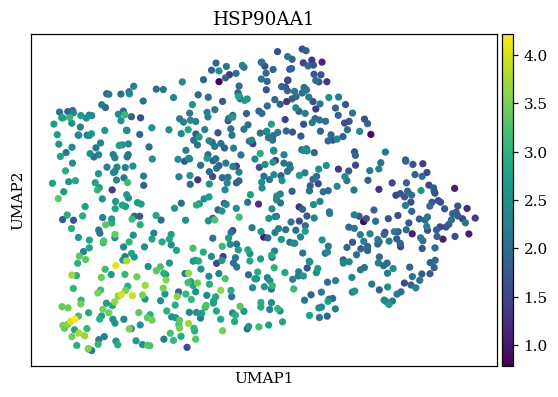

In [476]:
# sc._inplace_subset_var(sc.var["highly_variable"])

scanpy.pp.neighbors(sc, n_neighbors = 30, n_pcs = 15)
scanpy.tl.umap(sc, min_dist=0.5)
scanpy.pl.umap(sc, color = "HSP90AA1", gene_symbols="external_gene_name", use_raw=False, s = 90)

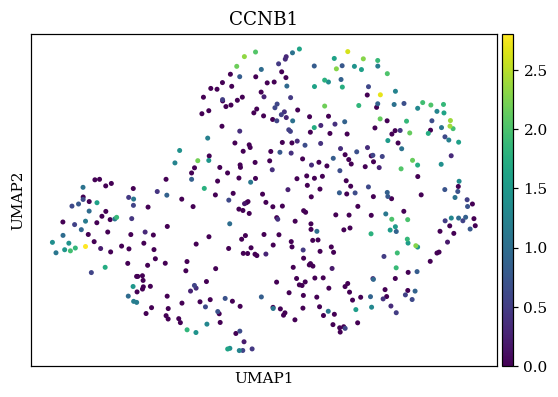

In [109]:
scanpy.pl.umap(sc, color = "CCNB1", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [565]:
scanpy.pp.neighbors(sc, n_neighbors = 30, use_rep="X_umap")
scanpy.tl.louvain(sc, resolution = 0.9)

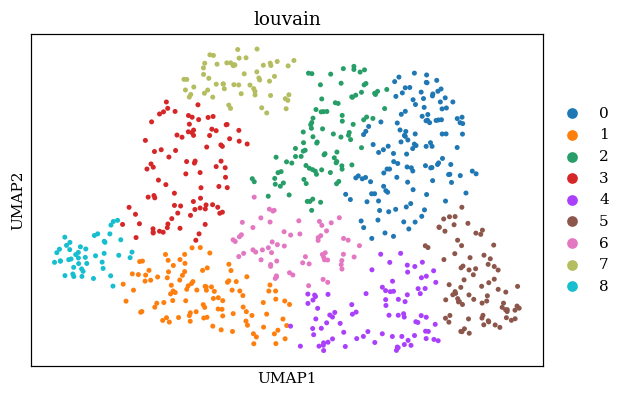

In [566]:
scanpy.pl.umap(sc, color = "louvain", gene_symbols="external_gene_name", use_raw=False, s = 43)

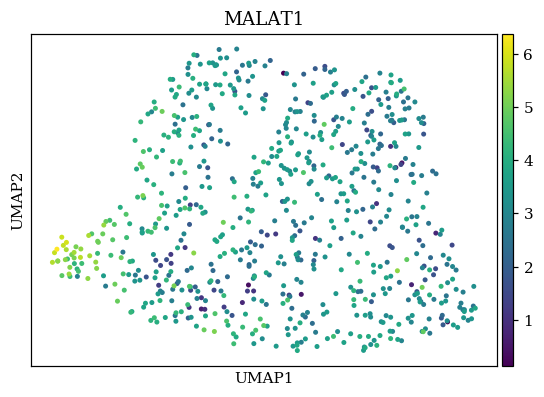

In [571]:
scanpy.pl.umap(sc, color = "MALAT1", gene_symbols="external_gene_name", use_raw=False, s = 43)

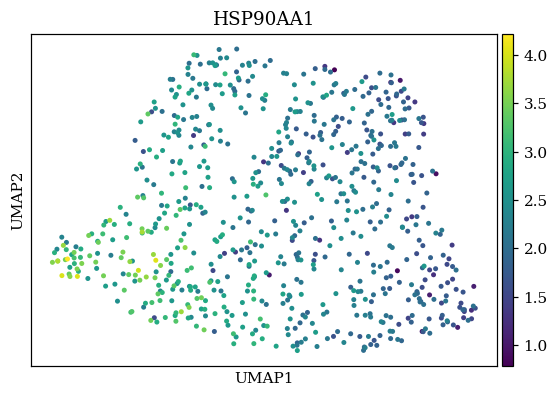

In [570]:
scanpy.pl.umap(sc, color = "HSP90AA1", gene_symbols="external_gene_name", use_raw=False, s = 43)

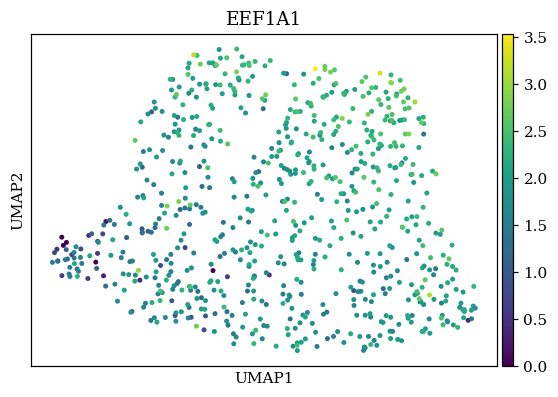

In [532]:
scanpy.pl.umap(sc, color = "EEF1A1", gene_symbols="external_gene_name", use_raw=False, s = 43)

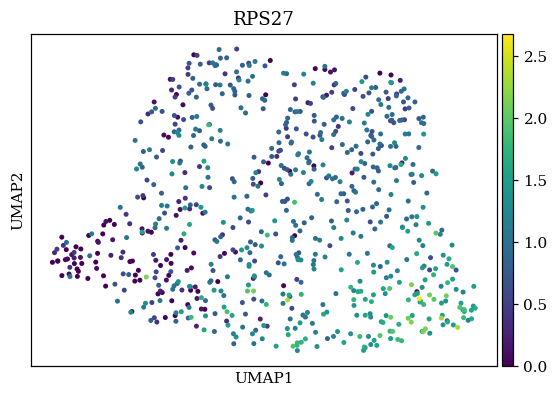

In [543]:
scanpy.pl.umap(sc, color = "RPS27", gene_symbols="external_gene_name", use_raw=False, s = 43)

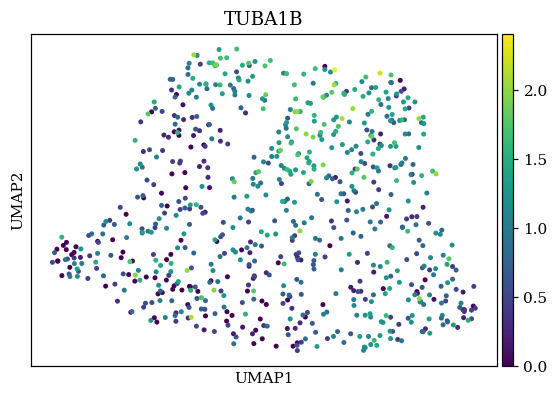

In [573]:
scanpy.pl.umap(sc, color = "TUBA1B", gene_symbols="external_gene_name", use_raw=False, s = 43)

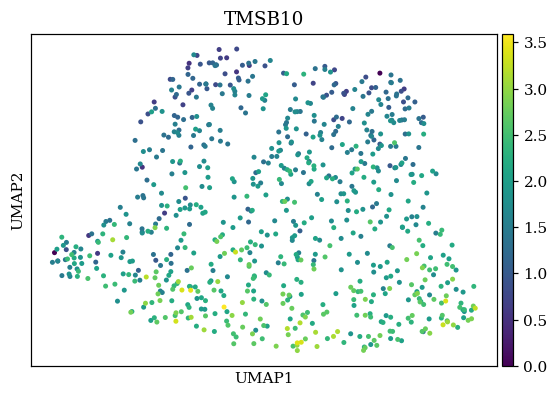

In [575]:
scanpy.pl.umap(sc, color = "TMSB10", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [505]:
sc.uns['iroot'] = np.flatnonzero(sc.obs['louvain']  == '6')[0]
scanpy.tl.dpt(sc)

In [506]:
sc.obs

index            CB  CorrectedReads  MappedReads  DeduplicatedReads  \
367     367  TGTGGTCTAAGC           22970        17139               6297   
425     425  TCGCGTCTACCC           17578        14156               5861   
2784   2784  TTCGTTAGATAC            2421         1699                853   
2015   2015  CGTTGACGGACC            2897         2127                828   
588     588  GGTGGAAGAACG            8291         6353               3067   
...     ...           ...             ...          ...                ...   
480     480  GTGAGGGTGCTG           14470        11612               4290   
2821   2821  TACTTGCGCGCA            2408         1445                650   
301     301  TTTCTTCACTGC           32377        18668               8166   
845     845  TCACAAATTCAG            4667         2999               1515   
641     641  GCGCTCTTTAGG            6810         3472               1996   

      MappingRate  DedupRate  MeanByMax  NumGenesExpressed  NumGenesOverMean  \
367      0.746147   0.632592   0.012981               2680               520   
425      0.805325   0.585971   0.035202               2485               515   
2784     0.701776   0.497940   0.108304                716               133   
2015     0.734208   0.610719   0.090571                653               122   
588      0.766253   0.517236   0.058441               1640               511   
...           ...        ...        ...                ...               ...   
480      0.802488   0.630555   0.013974               1633               339   
2821     0.600083   0.550173   0.018841                500                64   
301      0.576582   0.562567   0.002876               3093               606   
845      0.642597   0.494832   0.007569                967               183   
641      0.509838   0.425115   0.006077               1173               255   

      ...  #_genes  cell_lines  max_corr   mt_frac   rp_frac  louvain  \
367   ...     2678       HCC70  0.761905  0.001588  0.191416        5   
425   ...     2485       HCC70  0.833469  0.003071  0.177599        0   
2784  ...      716       HCC70  0.519168  0.003517  0.073740        3   
2015  ...      653       HCC70  0.530508  0.004831  0.099396        3   
588   ...     1640       HCC70  0.774149  0.005543  0.168194        3   
...   ...      ...         ...       ...       ...       ...      ...   
480   ...     1625       HCC70  0.852630  0.138259  0.187338        0   
2821  ...      499       HCC70  0.455369  0.140769  0.063403        6   
301   ...     3089       HCC70  0.824730  0.162283  0.086926        6   
845   ...      967       HCC70  0.601256  0.172937  0.060396        6   
641   ...     1173       HCC70  0.591804  0.179915  0.033993        6   

       S_score  G2M_score  phase  dpt_pseudotime  
367  -0.046605  -0.043028     G1        0.599508  
425  -0.012753   0.139323    G2M        0.609249  
2784  0.087697   0.271171    G2M        0.170718  
2015 -0.062207   0.129802    G2M        0.140939  
588  -0.020616   0.152187    G2M        0.433760  
...        ...        ...    ...             ...  
480  -0.005951   0.140444    G2M        0.972131  
2821 -0.073383  -0.015338     G1        0.462220  
301   0.005444   0.221483    G2M        0.207403  
845   0.001963   0.226949    G2M        0.391482  
641  -0.009492  -0.044944     G1        0.484374  

[744 rows x 25 columns]

... storing 'xroot' as categorical


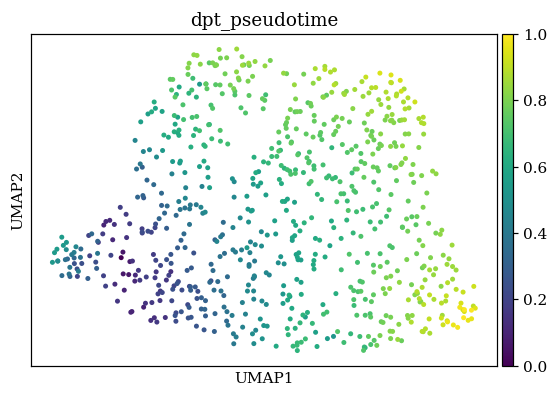

In [496]:
scanpy.pl.umap(sc, color = "dpt_pseudotime", gene_symbols="external_gene_name", use_raw=False, s = 43)

KeyError: 'dpt_groups'

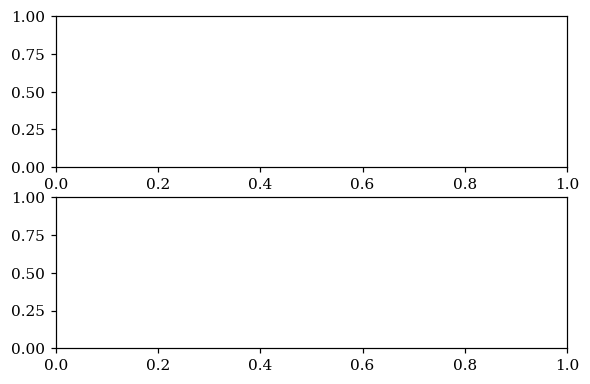

In [504]:
scanpy.pl.dpt_groups_pseudotime(sc)

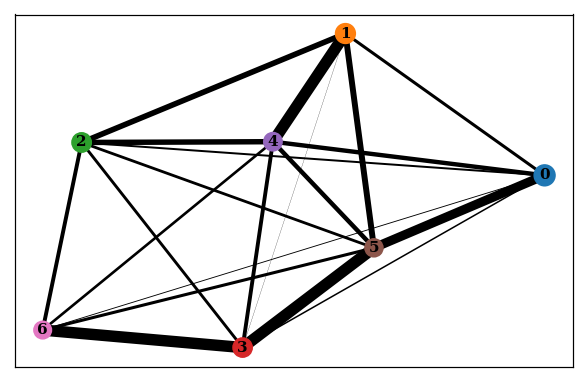

In [499]:
scanpy.pl.paga(sc, threshold=0.01, show=False)

In [464]:
cell_cycle_genes = np.array(['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG',
       'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'HELLS', 'RFC2',
       'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2',
       'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6',
       'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN',
       'POLA1', 'CHAF1B', 'BRIP1', 'E2F8', 'HMGB2', 'CDK1', 'NUSAP1',
       'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2',
       'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'SMC4', 'CCNB2',
       'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B',
       'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'CDC20', 'TTK', 'CDC25C',
       'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2',
       'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE',
       'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA'])

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
scanpy.tl.score_genes_cell_cycle(sc, s_genes = s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


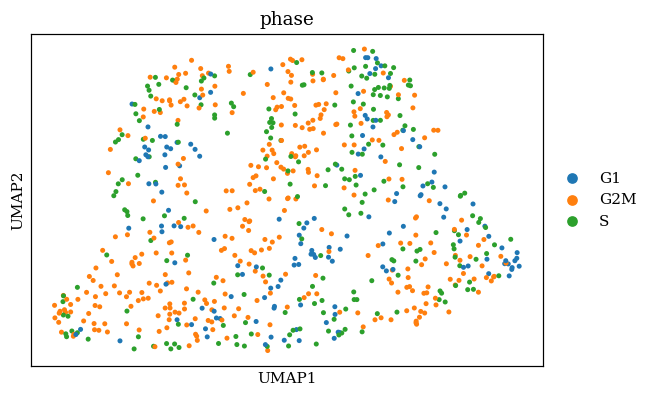

In [465]:
scanpy.pl.umap(sc, color = "phase", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [567]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="louvain", method = "wilcoxon", n_genes=150, rankby_abs=True)

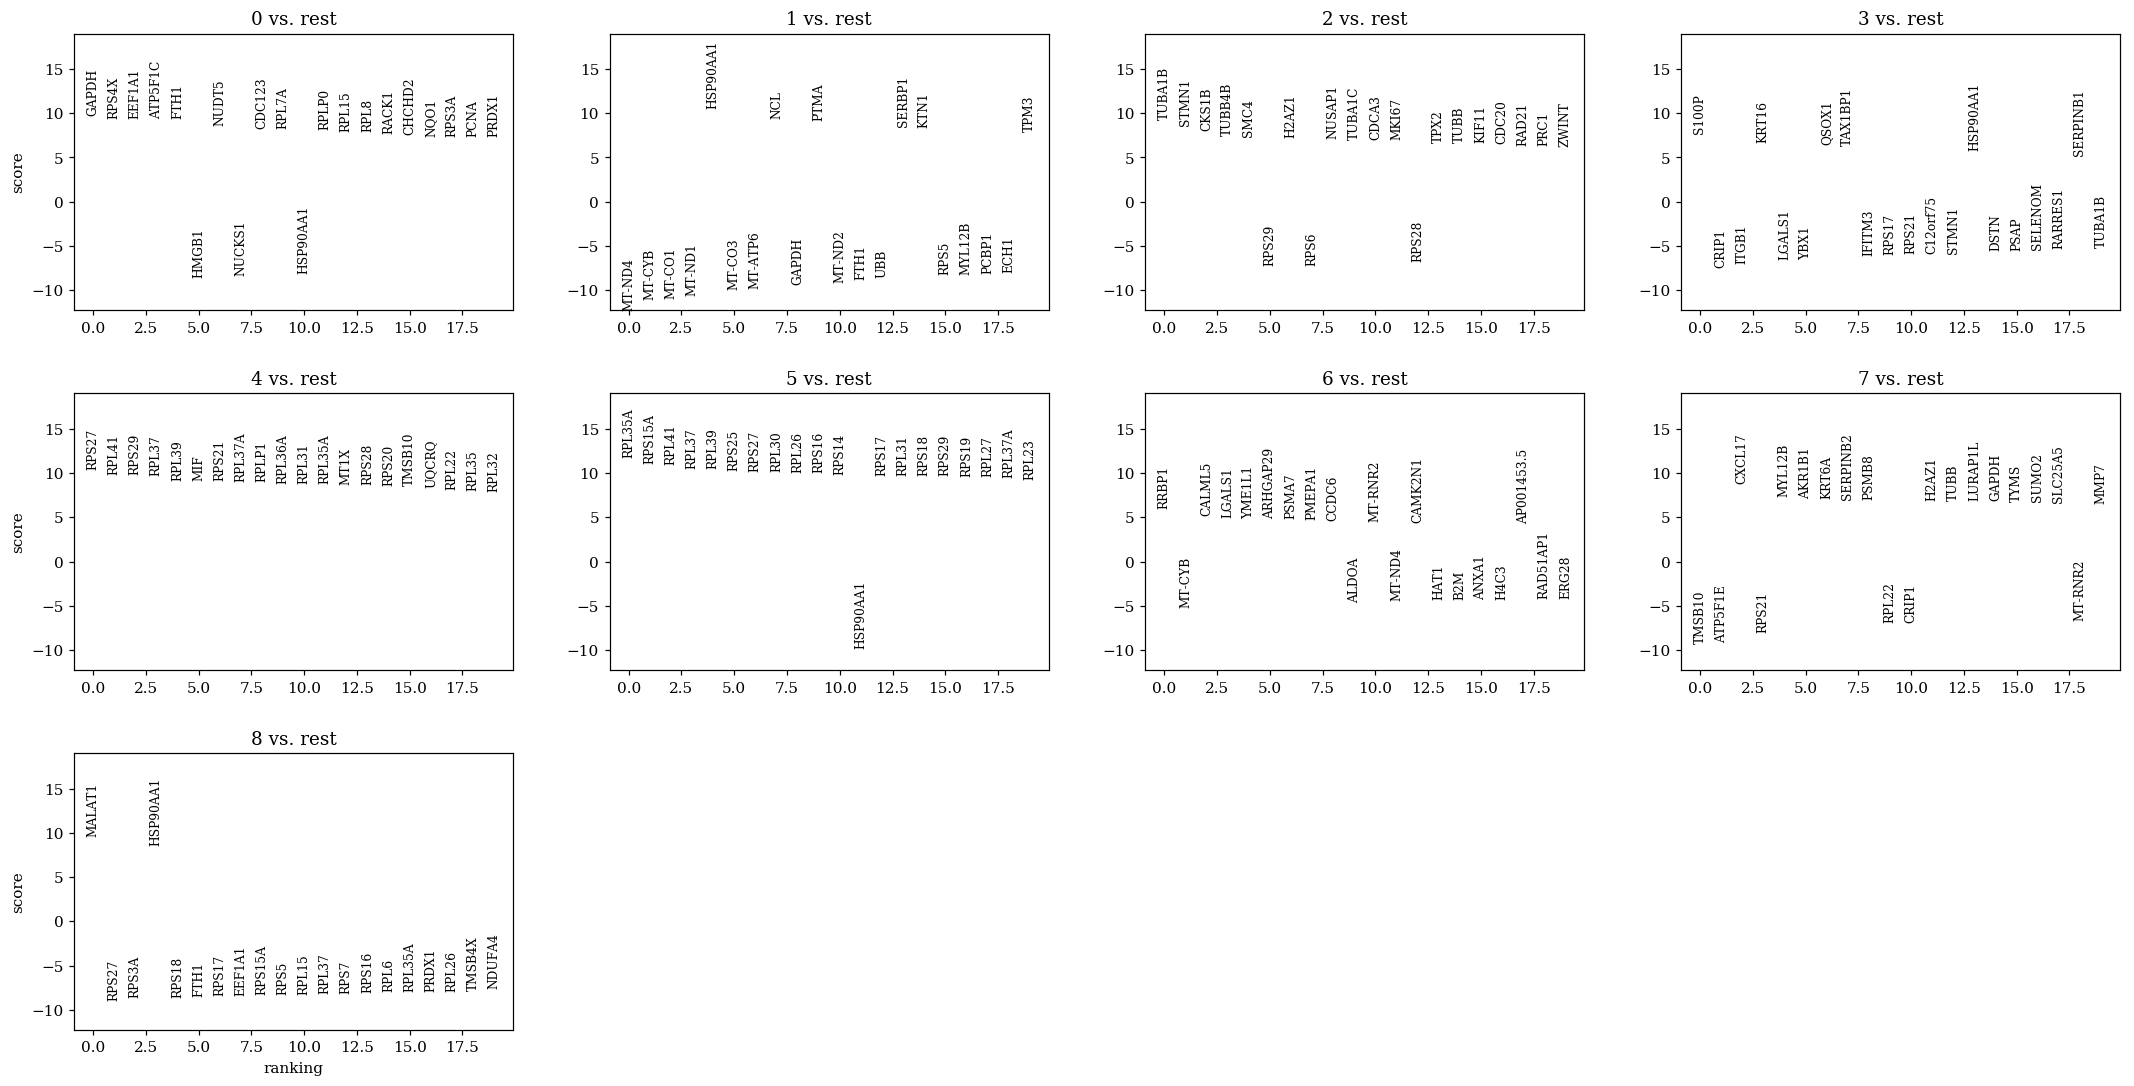

In [568]:
scanpy.pl.rank_genes_groups(sc, gene_symbols="external_gene_name")

In [231]:
[p[1] for p in sc.uns["rank_genes_groups"]["names"]]

['HSP90AA1',
 'MTDH',
 'NCL',
 'TPM3',
 'KTN1',
 'HMGB1',
 'PTMA',
 'HNRNPU',
 'EIF3A',
 'NUCKS1',
 'HSP90B1',
 'EIF5B',
 'ANP32B',
 'TMSB10',
 'SERBP1',
 'HDGF',
 'RBM25',
 'RRBP1',
 'EIF2S2',
 'DEK',
 'BAZ1B',
 'RPL21',
 'DHCR24',
 'DSP',
 'SSRP1',
 'ATP5F1E',
 'SYNE2',
 'SLTM',
 'SET',
 'LRRFIP1',
 'KIF5B',
 'CAST',
 'RPL22',
 'CBX3',
 'RPLP2',
 'SMARCA2',
 'PABPC1',
 'TPM1',
 'GOLGA4',
 'PSMA7',
 'DSTN',
 'GOLGB1',
 'NBPF19',
 'ANKRD11',
 'PARP1',
 'CSDE1',
 'RPL36A-HNRNPH2',
 'CAMK2N1',
 'RPS28',
 'METAP2',
 'TAX1BP1',
 'EIF3CL',
 'NBPF10',
 'SEM1',
 'SLPI',
 'HNRNPM',
 'HSP90AB1',
 'DNAJC21',
 'AL928654.3',
 'SERF2',
 'CENPF',
 'CALML5',
 'HSPH1',
 'MTRNR2L12',
 'GSPT1',
 'LMNA',
 'AC242842.3',
 'TOMM7',
 'PPM1G',
 'MYL6',
 'GTPBP4',
 'PTPRF',
 'SON',
 'EIF3C',
 'EIF1AX',
 'RALBP1',
 'SF3B2',
 'PUM3',
 'RNF103-CHMP3',
 'CLPTM1L',
 'AKAP9',
 'NASP',
 'HTATSF1',
 'KPNB1',
 'EZR',
 'RPL17',
 'PA2G4',
 'U2SURP',
 'GGT1',
 'RPS21',
 'DDX27',
 'EEF1D',
 'PTBP3',
 'NBPF20',
 'FKBP2',
 '

__QC before filtering__

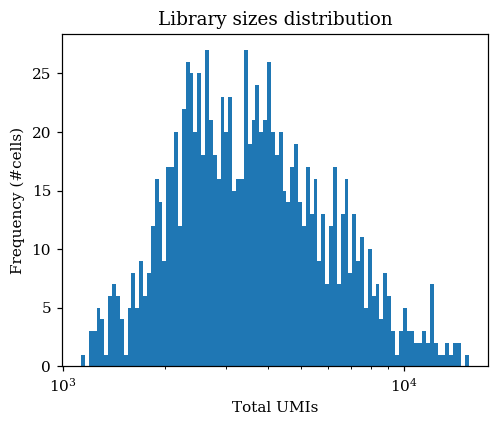

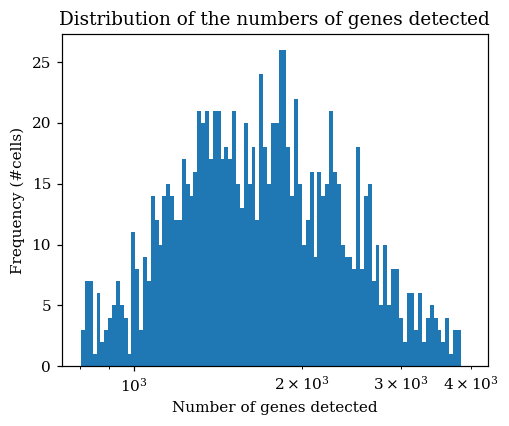

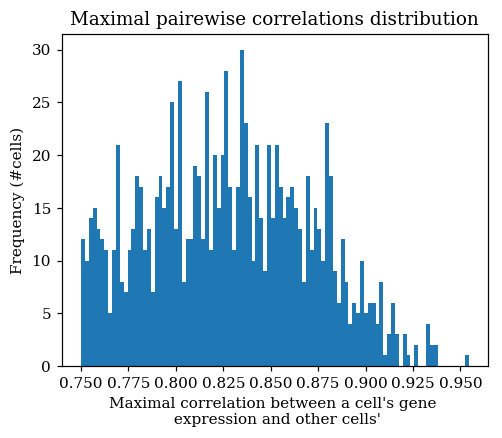

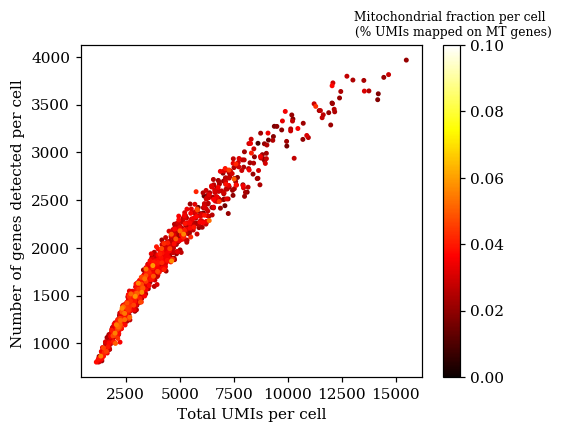

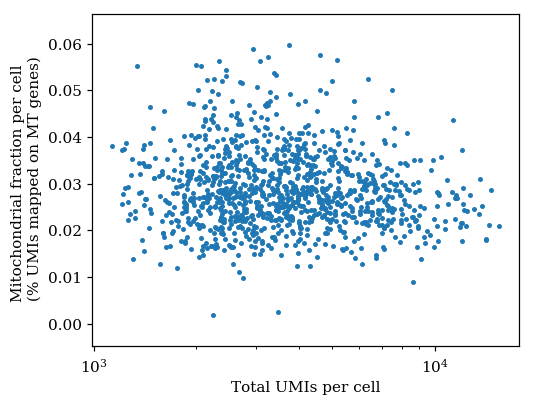

In [351]:
sc.plot_qc(show_cutoffs=False)

In [354]:
sc.write_filtered(save_path="../filtered_data/")